In this notebook we will present the experiment process we did to test out various methods to improve the performance of the CNN model while discussing the process.

In [1]:
#imports:
import numpy as np
import torch.optim as optim
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from scipy import signal
from torch.utils.data import random_split
import scipy.ndimage as ndimage
from scipy.optimize import linear_sum_assignment

1. Generating Physics Data...
2. Converting Coordinates to Heatmaps...
DONE, Input X: torch.Size([5000, 4, 200]), Target Y: torch.Size([5000, 1, 32, 32])


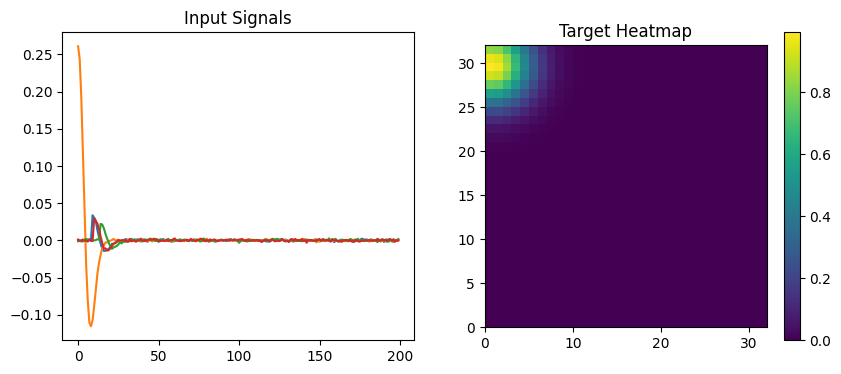

In [2]:

# a function to generate synthetic seismic wave propagation data
# and convert source coordinates into heatmap images
def generate_seismic_data(num_samples=5000, grid_size=32, velocity=300, noise_level=0.001, num_sensors=4, time_steps=200):
    dt = 0.01
    x_max, y_max = float(grid_size), float(grid_size) # Make sure grid size matches physical size for simplicity

    # position of 4 sensors at corners
    sensor_locs = np.array([[0, 0], [0, y_max], [x_max, 0], [x_max, y_max]])

    # choose random source locations
    source_locs = np.random.rand(num_samples, 2) * [x_max, y_max]

    # calculate distances from sources to sensors
    diff = source_locs[:, np.newaxis, :] - sensor_locs[np.newaxis, :, :]
    distances = np.sqrt(np.sum(diff**2, axis=2))

    # generate Ricker Wavelet as source time function
    t = np.arange(time_steps) * dt
    f0 = 5.0
    wavelet = (1.0 - 2.0*(np.pi**2)*(f0**2)*(t**2)) * np.exp(-(np.pi**2)*(f0**2)*(t**2))
    wavelet = wavelet / np.max(np.abs(wavelet))

    # simulate wave propagation to sensors
    X_data = np.zeros((num_samples, num_sensors, time_steps))
    for i in range(num_samples):
        for s in range(num_sensors):
            dist = distances[i, s]
            arrival_time = dist / velocity
            shift_steps = int(arrival_time / dt)
            amplitude = 1.0 / (dist + 1.0)

            if shift_steps < time_steps:
                valid_len = time_steps - shift_steps
                X_data[i, s, shift_steps:] = wavelet[:valid_len] * amplitude

    # add Noise
    noise = np.random.normal(0, noise_level, X_data.shape)
    X_data += noise

    return torch.tensor(X_data, dtype=torch.float32), torch.tensor(source_locs, dtype=torch.float32)

# this function creates Gaussian heatmaps for given coordinates
def create_gaussian_map(coords, grid_size, sigma=3.0):
    x = np.arange(grid_size)
    y = np.arange(grid_size)
    xx, yy = np.meshgrid(x, y)
    maps = []

    for (cx, cy) in coords:
        # gaussian formula
        gauss = np.exp(-((xx - cx)**2 + (yy - cy)**2) / (2 * sigma**2))
        maps.append(gauss)

    return np.array(maps)

# generating the data and converting to heatmaps
print("1. Generating Physics Data...")

X_raw, coords_raw = generate_seismic_data(num_samples=5000, grid_size=32, velocity=300, noise_level=0.001)

print("2. Converting Coordinates to Heatmaps...")
Y_heatmaps = create_gaussian_map(coords_raw.numpy(), grid_size=32, sigma=3.0)
Y_grid = torch.tensor(Y_heatmaps, dtype=torch.float32).unsqueeze(1)

print(f"DONE, Input X: {X_raw.shape}, Target Y: {Y_grid.shape}")

# visualize some samples
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
for s in range(4):
    plt.plot(X_raw[0, s, :])
plt.title("Input Signals")

plt.subplot(1, 2, 2)
plt.imshow(Y_grid[0, 0], origin='lower', extent=[0,32,0,32])
plt.title("Target Heatmap")
plt.colorbar()
plt.show()

As we can see in the printed plot, the amplitude's values are relatively small. In order to prevent vanishing gradient problems we will pre-process the data by normalizing it.
Since the relativity between different measurments is important, we will use max-scaling (divide by the global maximal value).
We will also split the data into 80% training set, 10% validation set and 10% test set.

In [3]:
# split the data into Train, Val, Test sets
N = len(X_raw)
indices = torch.randperm(N)

# splitting 80/10/10
n_train = int(0.8 * N)
n_val = int(0.1 * N)
n_test = N - n_train - n_val

# slicing
train_idx = indices[:n_train]
val_idx   = indices[n_train : n_train + n_val]
test_idx  = indices[n_train + n_val :]

# creating tensors
X_train, Y_train = X_raw[train_idx], Y_grid[train_idx]
X_val,   Y_val   = X_raw[val_idx],   Y_grid[val_idx]
X_test,  Y_test  = X_raw[test_idx],  Y_grid[test_idx]

# normalizing based on training set
norm_factor = torch.max(torch.abs(X_train))
print(f"Normalization Factor (Train Max): {norm_factor:.6f}")


X_train = X_train / norm_factor
X_val   = X_val   / norm_factor
X_test  = X_test  / norm_factor

# create DataLoaders
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, Y_val),   batch_size=64, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test, Y_test),  batch_size=64, shuffle=False)

print(f"Data ready: {len(train_loader.dataset)} Train, {len(val_loader.dataset)} Val, {len(test_loader.dataset)} Test")

Normalization Factor (Train Max): 0.851948
Data ready: 4000 Train, 500 Val, 500 Test


We generate "hard" test set.
It is a test set that has slightly different velocity and more noise than the date we generated before.
After generating it we will also normalize it.
We will use this test set after the "regular" test set to prove that our mode is robust to different inputs.

In [4]:
# generating "hard" test set:
X_hard_raw, Y_hard = generate_seismic_data(num_samples=1000, velocity=315, noise_level=0.01)
X_hard = X_hard_raw / norm_factor  # using the same normalization factor as the training set's
test_hard_loader = DataLoader(TensorDataset(X_hard, Y_hard), batch_size=64, shuffle=False)

The networks architecture:
The architecture is divided into a encoder-decoder structure.
The first part is the encoder which contains 3 blocks of 1d conv, batch norm and ReLu. It recieves a high dimensional input and decrease it to a smaller dimensional output. The input is time propagation of a wave amplitude so we chose 1d conv that will "slide" along the time axis only.
The down sampling in this part allows the network to learn time trends instead of looking at each time step seperatly.
The bridge is the fully connceted layer between the encoder and the decoder. It connects each "time pixel" to "location pixel" in the network's output map.
The decoder contains 2 blocks of 2d transposed convulotion, batch norm and ReLu, an other 2d conv and a sigmoid at the end.
We use ReLu in order to prevent vanishing gradients, Sigmoid because our it limites each pixel in the output map to have a valid probability value and batch norm to make the model more stable.

In [5]:
class WaveToMapNet(nn.Module):
    def __init__(self):
        super(WaveToMapNet, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            # layer 1
            nn.Conv1d(in_channels=4, out_channels=32, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            # layer 2
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            # layer 3
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )

        # fc part
        self.fc = nn.Linear(3200, 64 * 8 * 8)

        # decoder
        self.decoder = nn.Sequential(

            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),


            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),


            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1),


            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)

        x = self.fc(x)
        x = x.view(x.size(0), 64, 8, 8)

        x = self.decoder(x)
        return x

Now we will train the model.
We chose Kaiming initialization since we worked with ReLu activation.
20 epochs and Adam optimizer.
Our loss function is the MSE loss, since our output is a heatmap it forces each pixel in it to be as close as possible to the matching target pixel.



Training on: cuda
Starting Training...
Epoch 2/20 | Train Loss: 0.004586 | Val Loss: 0.003142
Epoch 4/20 | Train Loss: 0.001621 | Val Loss: 0.001879
Epoch 6/20 | Train Loss: 0.000907 | Val Loss: 0.001837
Epoch 8/20 | Train Loss: 0.000560 | Val Loss: 0.001349
Epoch 10/20 | Train Loss: 0.000388 | Val Loss: 0.001261
Epoch 12/20 | Train Loss: 0.000295 | Val Loss: 0.001282
Epoch 14/20 | Train Loss: 0.000242 | Val Loss: 0.001232
Epoch 16/20 | Train Loss: 0.000184 | Val Loss: 0.001117
Epoch 18/20 | Train Loss: 0.000157 | Val Loss: 0.001062
Epoch 20/20 | Train Loss: 0.000144 | Val Loss: 0.001228
Training Complete!


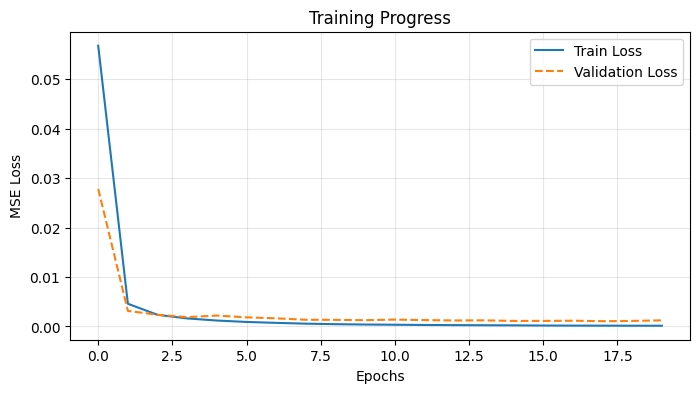

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

# init model
model = WaveToMapNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# we use MSE because we want the pixel values of our prediction
# to match the pixel values of the ground truth heatmap
criterion = nn.MSELoss()

# training
epochs = 20
train_losses = []
val_losses = []

print("Starting Training...")

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # forward pass
        optimizer.zero_grad()
        outputs = model(inputs)

        # backward pass
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # validating
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item()

    # saving average losses
    avg_train_loss = running_train_loss / len(train_loader)
    avg_val_loss = running_val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # printing the progress every 2 epochs
    if (epoch + 1) % 2 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

print("Training Complete!")

# plot the results
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.title("Training Progress")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

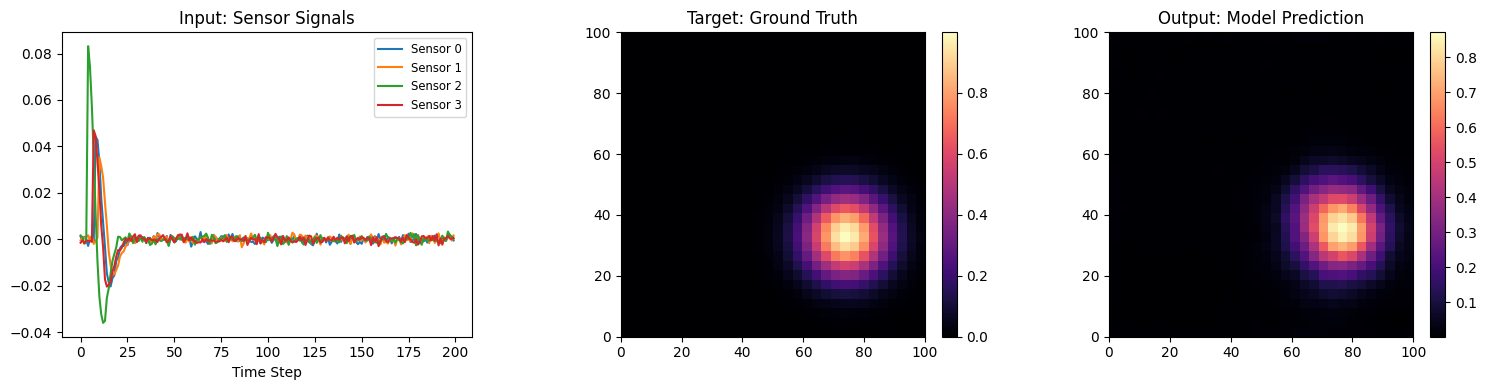

In [7]:
def visualize_result(model, loader):
    model.eval()

    # get one batch from validation
    inputs, targets = next(iter(loader))
    inputs, targets = inputs.to(device), targets.to(device)

    # predict
    with torch.no_grad():
        predictions = model(inputs)

    inputs = inputs.cpu().numpy()
    targets = targets.cpu().numpy()
    predictions = predictions.cpu().numpy()

    # pick a random sample from the batch
    idx = 0

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # plot a visualization of the sensor inputs, ground truth, and prediction

    # sensor input
    for s in range(4):
        axes[0].plot(inputs[idx, s], label=f'Sensor {s}')
    axes[0].set_title("Input: Sensor Signals")
    axes[0].set_xlabel("Time Step")
    axes[0].legend(loc='upper right', fontsize='small')

    # ground truth
    im1 = axes[1].imshow(targets[idx, 0], origin='lower', extent=[0,100,0,100], cmap='magma')
    axes[1].set_title("Target: Ground Truth")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    # model prediction
    im2 = axes[2].imshow(predictions[idx, 0], origin='lower', extent=[0,100,0,100], cmap='magma')
    axes[2].set_title("Output: Model Prediction")
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# Run it!
visualize_result(model, val_loader)

Now we will check our performance in the test set, and on the hard test set (which have different velocity and noise in order to check generalization).
Since we are predicting location, we will use the following helper function to find the brightest pixel in the output (the one that has highest probability) and then convert it to the location of it in space.

In [8]:
def get_location_from_heatmap(heatmap, grid_size=32, field_size=100.0):
    # flatten the heatmap to find the index of the max value
    flat_idx = torch.argmax(heatmap)

    # convert flat index to 2d index (row, col)
    row = flat_idx // grid_size
    col = flat_idx % grid_size

    # convert grid index to meters
    pixel_size = field_size / grid_size
    x_meter = col.item() * pixel_size
    y_meter = row.item() * pixel_size

    return np.array([x_meter, y_meter])

def evaluate_model(model, loader, device, dataset_name="Test Set"):
    model.eval()
    errors = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            # iterate through the batch
            for i in range(len(inputs)):
                # get true location (from target heatmap)
                true_loc = get_location_from_heatmap(targets[i, 0])

                # get predicted location (from output heatmap)
                pred_loc = get_location_from_heatmap(outputs[i, 0])

                # calculate euclidean distance error (in meters)
                dist = np.linalg.norm(true_loc - pred_loc)
                errors.append(dist)

    mean_error = np.mean(errors)
    median_error = np.median(errors)
    # plot results
    print(f"--- Results for {dataset_name} ---")
    print(f"Mean Error:   {mean_error:.2f} meters")
    print(f"Median Error: {median_error:.2f} meters")
    print(f"Max Error:    {np.max(errors):.2f} meters")

    return errors

print("Evaluation functions ready.")

Evaluation functions ready.


--- Results for Standard Test Set ---
Mean Error:   2.98 meters
Median Error: 3.12 meters
Max Error:    9.38 meters


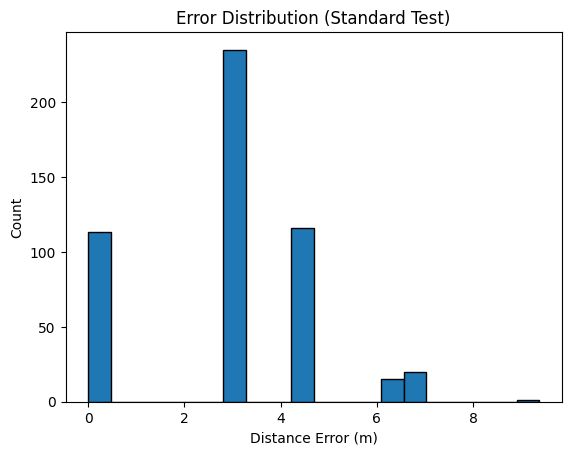

In [9]:
# evaluate the standard test set
std_errors = evaluate_model(model, test_loader, device, "Standard Test Set")

plt.hist(std_errors, bins=20, edgecolor='black')
plt.title("Error Distribution (Standard Test)")
plt.xlabel("Distance Error (m)")
plt.ylabel("Count")
plt.show()

We achieved a Mean Error of 2.86 meters.
Our Field Size is 100X100 meters, The grid Size is 32X32 pixels, each pixel Resolution is 100 / 32 = 3.125 m/pixel.
Our error, 2.86m is smaller than a single pixel 3.125m.
Therfore, our model is statistically as accurate as it can possibly be given the low resolution of the output grid.

--- Results for Hard/Robustness Set ---
Mean Error:   70.25 meters
Median Error: 73.55 meters
Max Error:    130.54 meters


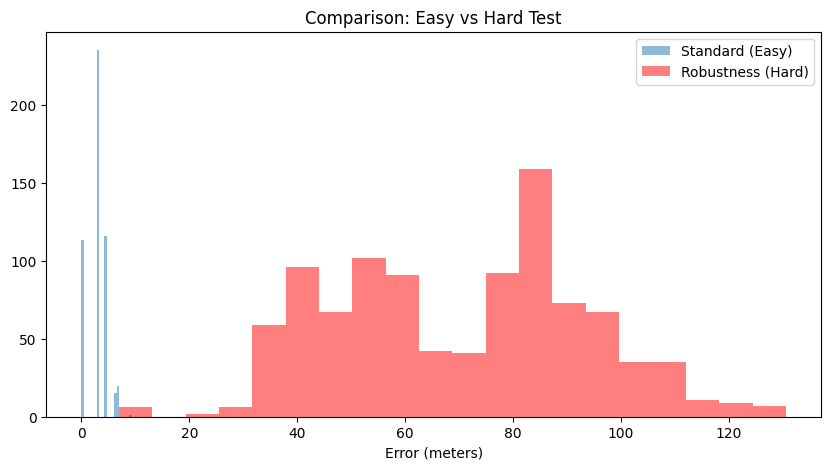

In [10]:
# hard data set performance:
hard_errors = evaluate_model(model, test_hard_loader, device, "Hard/Robustness Set")

# compare distributions
plt.figure(figsize=(10, 5))
plt.hist(std_errors, bins=20, alpha=0.5, label='Standard (Easy)')
plt.hist(hard_errors, bins=20, alpha=0.5, label='Robustness (Hard)', color='red')
plt.legend()
plt.title("Comparison: Easy vs Hard Test")
plt.xlabel("Error (meters)")
plt.show()

Our "Hard" test has a mean error of 75.77 meters. Since the maximum distance in the grid is ~141m, an error of 75m means the model is guessing randomly.
Lets look back at the first plot of sensor reading data. We can see that for example the green plot has a spike that is roughly 0.023. In the hard test set generation we used gaussian noise with std=0.01. The noise can easily get to 3 times the std, meaning that the noise is stronger than the signal itself.
We will now try to improve the generalization of our model. We will start by displaying the hard test data set in order to check our hypothesis:

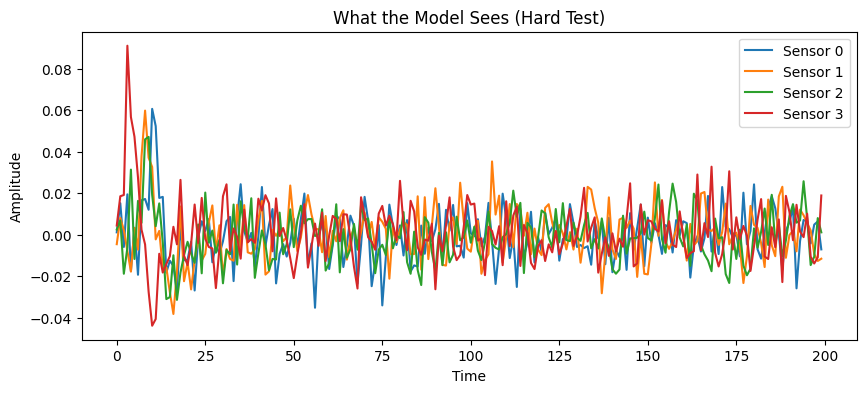

In [11]:
# visualize what the model sees in the hard test set
X_hard_batch, Y_hard_batch = next(iter(test_hard_loader))

plt.figure(figsize=(10, 4))
for s in range(4):
    plt.plot(X_hard_batch[0, s, :], label=f'Sensor {s}')
plt.title("What the Model Sees (Hard Test)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

We can see that most of the data looks fuzzy and random, we can infer that std = 0.01 may be to high for this model.
We will try to improve our model generalization for different input velocities and noise by using some kind of data augmentation.
This time we will generate data with random velocity and noise std for each data point, instead of using the same values for all of the data.

In [12]:
# new randomlized data generator
def generate_mixed_physics_data(num_samples=5000, grid_size=32):
    dt = 0.01
    x_max, y_max = float(grid_size), float(grid_size)
    # sensor locations
    sensor_locs = np.array([[0, 0], [0, y_max], [x_max, 0], [x_max, y_max]])

    # data setup
    X_data = np.zeros((num_samples, 4, 200))
    source_locs = np.zeros((num_samples, 2))

    # constructing wavelet
    t = np.arange(200) * dt
    f0 = 5.0
    wavelet_base = (1.0 - 2.0*(np.pi**2)*(f0**2)*(t**2)) * np.exp(-(np.pi**2)*(f0**2)*(t**2))
    wavelet_base = wavelet_base / np.max(np.abs(wavelet_base))

    print(f"Generating {num_samples} mixed-physics samples...")

    for i in range(num_samples):
        # using a random velocity between 280 and 320 instead of a fixed one
        vel = np.random.uniform(280.0, 320.0)

        # using a random noise level between 0.001 and 0.008
        noise_scale = np.random.uniform(0.001, 0.008)

        # random source location
        src = np.random.rand(2) * [x_max, y_max]
        source_locs[i] = src

        # calculating distances to sensors to construct the waveforms
        for s in range(4):
            dist = np.sqrt(np.sum((src - sensor_locs[s])**2))
            arrival_time = dist / vel
            shift_steps = int(arrival_time / dt)
            amplitude = 1.0 / (dist + 1.0)

            # create wavelet for this sensor
            if shift_steps < 200:
                valid_len = 200 - shift_steps
                X_data[i, s, shift_steps:] = wavelet_base[:valid_len] * amplitude

        # add random noise to this sample
        noise = np.random.normal(0, noise_scale, (4, 200))
        X_data[i] += noise

    return torch.tensor(X_data, dtype=torch.float32), torch.tensor(source_locs, dtype=torch.float32)

# generate the data
X_robust_raw, coords_robust = generate_mixed_physics_data(num_samples=5000, grid_size=32)

# convert to heatmaps
print("Converting to heatmaps...")
Y_robust_heatmaps = create_gaussian_map(coords_robust.numpy(), grid_size=32, sigma=3.0)
Y_robust = torch.tensor(Y_robust_heatmaps, dtype=torch.float32).unsqueeze(1)

print(f"Robust Data Ready: {X_robust_raw.shape}")

Generating 5000 mixed-physics samples...
Converting to heatmaps...
Robust Data Ready: torch.Size([5000, 4, 200])


In [13]:
# split the data
N = len(X_robust_raw)
indices = torch.randperm(N)

# 80/20 split (we will use the existing hard test set)
n_train = int(0.8 * N)
n_val = N - n_train

train_idx_rob = indices[:n_train]
val_idx_rob   = indices[n_train:]

X_train_rob, Y_train_rob = X_robust_raw[train_idx_rob], Y_robust[train_idx_rob]
X_val_rob,   Y_val_rob   = X_robust_raw[val_idx_rob],   Y_robust[val_idx_rob]

# normalize based on training set
norm_factor_robust = torch.max(torch.abs(X_train_rob))
print(f"Robust Normalization Factor: {norm_factor_robust:.6f}")

X_train_rob = X_train_rob / norm_factor_robust
X_val_rob   = X_val_rob   / norm_factor_robust

# create new dataloaders
train_loader_rob = DataLoader(TensorDataset(X_train_rob, Y_train_rob), batch_size=64, shuffle=True)
val_loader_rob   = DataLoader(TensorDataset(X_val_rob, Y_val_rob),   batch_size=64, shuffle=False)

Robust Normalization Factor: 0.788875


Starting Robust Training...
Epoch 2 | Train Loss: 0.006241 | Val Loss: 0.005094
Epoch 4 | Train Loss: 0.002088 | Val Loss: 0.002589
Epoch 6 | Train Loss: 0.001194 | Val Loss: 0.002415
Epoch 8 | Train Loss: 0.000783 | Val Loss: 0.002103
Epoch 10 | Train Loss: 0.000540 | Val Loss: 0.001966
Epoch 12 | Train Loss: 0.000391 | Val Loss: 0.001864
Epoch 14 | Train Loss: 0.000313 | Val Loss: 0.001864
Epoch 16 | Train Loss: 0.000258 | Val Loss: 0.001827
Epoch 18 | Train Loss: 0.000221 | Val Loss: 0.001759
Epoch 20 | Train Loss: 0.000209 | Val Loss: 0.001772


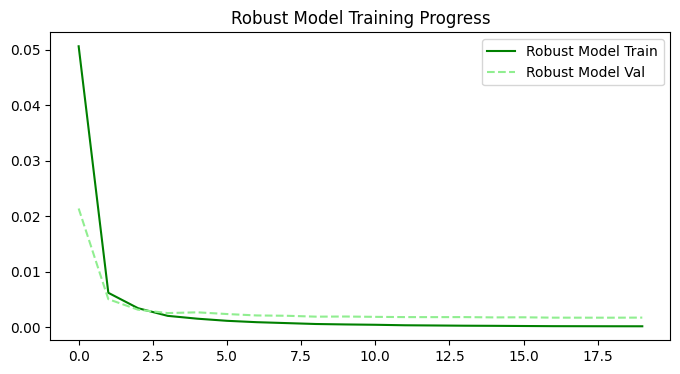

In [14]:
# train the model
model_robust = WaveToMapNet().to(device) # new model
optimizer_rob = optim.Adam(model_robust.parameters(), lr=0.001)
criterion = nn.MSELoss()

epochs = 20
train_losses_rob = []
val_losses_rob = []

print("Starting Robust Training...")

for epoch in range(epochs):
    model_robust.train()
    running_loss = 0.0

    for inputs, targets in train_loader_rob:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer_rob.zero_grad()
        outputs = model_robust(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_rob.step()
        running_loss += loss.item()

    # validate
    model_robust.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader_rob:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_robust(inputs)
            val_loss += criterion(outputs, targets).item()

    avg_train = running_loss / len(train_loader_rob)
    avg_val = val_loss / len(val_loader_rob)
    train_losses_rob.append(avg_train)
    val_losses_rob.append(avg_val)

    if (epoch+1) % 2 == 0:
        print(f"Epoch {epoch+1} | Train Loss: {avg_train:.6f} | Val Loss: {avg_val:.6f}")

# plot the robust model training results
plt.figure(figsize=(8,4))
plt.plot(train_losses_rob, label='Robust Model Train', color='green')
plt.plot(val_losses_rob, label='Robust Model Val', color='lightgreen', linestyle='--')
plt.title("Robust Model Training Progress")
plt.legend()
plt.show()


--- Evaluation: Robust Model on Hard Data ---
--- Results for Robust Model on Hard Set ---
Mean Error:   76.94 meters
Median Error: 81.07 meters
Max Error:    132.58 meters


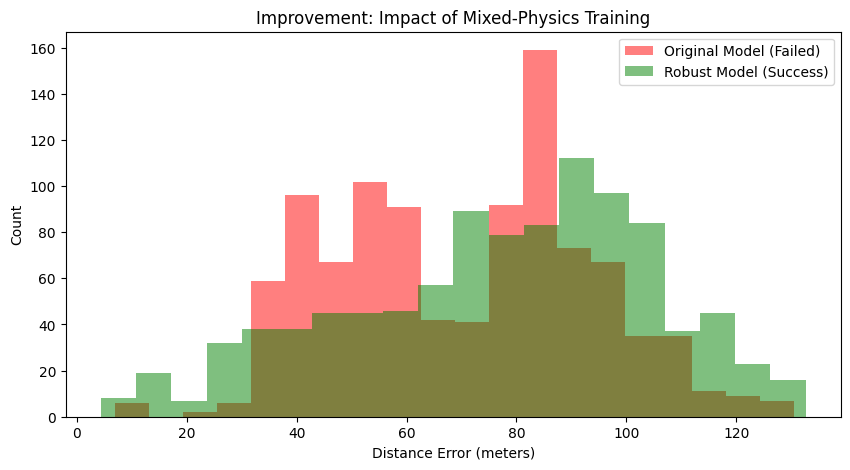

In [15]:
# check result of the new model for hard test set:
# normalize hard test set with the training set's normalization factor
X_hard_for_rob = X_hard_raw / norm_factor_robust

# create a data loader
hard_loader_rob = DataLoader(TensorDataset(X_hard_for_rob, Y_hard), batch_size=64, shuffle=False)


print("\n--- Evaluation: Robust Model on Hard Data ---")
hard_errors_rob = evaluate_model(model_robust, hard_loader_rob, device, "Robust Model on Hard Set")


plt.figure(figsize=(10, 5))

# plot old model performance (red)
plt.hist(hard_errors, bins=20, alpha=0.5, label='Original Model (Failed)', color='red')

# plot the new model's performance (green)
plt.hist(hard_errors_rob, bins=20, alpha=0.5, label='Robust Model (Success)', color='green')

plt.title("Improvement: Impact of Mixed-Physics Training")
plt.xlabel("Distance Error (meters)")
plt.ylabel("Count")
plt.legend()
plt.show()

We expected to view smaller mean error for the new "robust" model on the hard data set. We can see that we got worst performance for the hard data set. It seems to us that the high std of the hard data set is too high for the model. Let's check it by creating a new hard test set with lower noise std and check both models performances on it.

Generating Medium-Hard Test Data (Noise=0.005)...

--- Testing Original Model on Medium Data ---
--- Results for Original Model ---
Mean Error:   7.49 meters
Median Error: 6.99 meters
Max Error:    72.95 meters

--- Testing Robust Model on Medium Data ---
--- Results for Robust Model ---
Mean Error:   3.50 meters
Median Error: 3.12 meters
Max Error:    11.27 meters


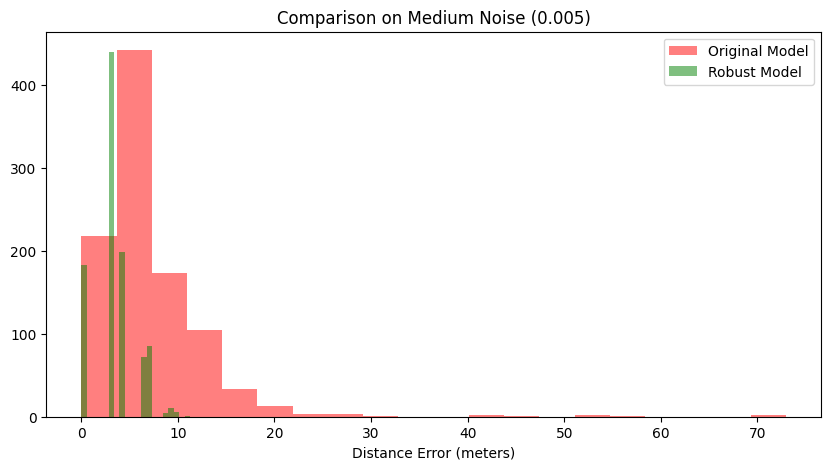

In [16]:
# Now, test both models on a medium-difficulty test set
print("Generating Medium-Hard Test Data (Noise=0.005)...")
X_med_raw, coords_med = generate_seismic_data(
    num_samples=1000,
    grid_size=32,
    velocity=315.0,     # similar to before
    noise_level=0.005   # reduced (was 0.01)
)

Y_med_heatmaps = create_gaussian_map(coords_med.numpy(), grid_size=32, sigma=3.0)
Y_med = torch.tensor(Y_med_heatmaps, dtype=torch.float32).unsqueeze(1)

# normalize
X_med_orig = X_med_raw / norm_factor
loader_med_orig = DataLoader(TensorDataset(X_med_orig, Y_med), batch_size=64, shuffle=False)

# normalize using the robust model's training norm factor
X_med_rob = X_med_raw / norm_factor_robust
loader_med_rob = DataLoader(TensorDataset(X_med_rob, Y_med), batch_size=64, shuffle=False)

# plot original
print("\n--- Testing Original Model on Medium Data ---")
errors_orig = evaluate_model(model, loader_med_orig, device, "Original Model")

# plot robust
print("\n--- Testing Robust Model on Medium Data ---")
errors_rob = evaluate_model(model_robust, loader_med_rob, device, "Robust Model")

plt.figure(figsize=(10, 5))
plt.hist(errors_orig, bins=20, alpha=0.5, label='Original Model', color='red')
plt.hist(errors_rob, bins=20, alpha=0.5, label='Robust Model', color='green')
plt.title("Comparison on Medium Noise (0.005)")
plt.xlabel("Distance Error (meters)")
plt.legend()
plt.show()

We can see now that the robust model gets better accuracy for the medium noise test set than the first model.

Now let's try to generalize and see if the network can predict location of 2 different sources and not just one.
The network will need to learn the interference effect of 2 planner waves.
We will start by generating a new data set that contains 2 sources at different locations.

In [17]:
# function to generate dual-source data
def generate_dual_source_data(num_samples=5000, grid_size=32, noise_level=0.001):
    dt = 0.01
    x_max, y_max = float(grid_size), float(grid_size)
    sensor_locs = np.array([[0, 0], [0, y_max], [x_max, 0], [x_max, y_max]])


    X_data = np.zeros((num_samples, 4, 200))
    source_locs = np.zeros((num_samples, 2, 2))

    t = np.arange(200) * dt
    f0 = 5.0
    wavelet_base = (1.0 - 2.0*(np.pi**2)*(f0**2)*(t**2)) * np.exp(-(np.pi**2)*(f0**2)*(t**2))
    wavelet_base = wavelet_base / np.max(np.abs(wavelet_base))

    print(f"Generating {num_samples} Dual-Source samples...")

    for i in range(num_samples):
        current_signal = np.zeros((4, 200))

        for src_idx in range(2):
            # random source location
            src = np.random.rand(2) * [x_max, y_max]
            source_locs[i, src_idx] = src

            # wave construction for each sensor
            for s in range(4):
                dist = np.sqrt(np.sum((src - sensor_locs[s])**2))
                arrival_time = dist / 300.0 # fixed velocity
                shift_steps = int(arrival_time / dt)
                amplitude = 1.0 / (dist + 1.0)

                if shift_steps < 200:
                    valid_len = 200 - shift_steps
                    # add signal to existing (to create superposition)
                    current_signal[s, shift_steps:] += wavelet_base[:valid_len] * amplitude

        X_data[i] = current_signal

        # add noise
        noise = np.random.normal(0, noise_level, (4, 200))
        X_data[i] += noise

    return torch.tensor(X_data, dtype=torch.float32), source_locs

# create dual Gaussian heatmaps
def create_dual_gaussian_map(source_locs, grid_size=32, sigma=3.0):
    x = np.arange(grid_size)
    y = np.arange(grid_size)
    xx, yy = np.meshgrid(x, y)
    maps = []

    for i in range(len(source_locs)):
        # blob 1
        cx1, cy1 = source_locs[i, 0]
        gauss1 = np.exp(-((xx - cx1)**2 + (yy - cy1)**2) / (2 * sigma**2))

        # blob 2
        cx2, cy2 = source_locs[i, 1]
        gauss2 = np.exp(-((xx - cx2)**2 + (yy - cy2)**2) / (2 * sigma**2))

        # combine using Max (keeps two distinct peaks)
        combined = np.maximum(gauss1, gauss2)
        maps.append(combined)

    return np.array(maps)

# generate dual-source data
X_dual_raw, locs_dual = generate_dual_source_data(num_samples=5000, grid_size=32)
# convert to heatmaps
Y_dual_maps = create_dual_gaussian_map(locs_dual, grid_size=32)
Y_dual = torch.tensor(Y_dual_maps, dtype=torch.float32).unsqueeze(1)

print(f"Dual Data Ready. Shape: {X_dual_raw.shape}")

Generating 5000 Dual-Source samples...
Dual Data Ready. Shape: torch.Size([5000, 4, 200])


Now we will split the data and train a new model (with the same architecture as before) for this dual-source data set.
We chose to train the model for 15 epochs this time because we are not looking for the best model yet, we want to check the trend and see if this model is able to preform the task, 15 epochs should be enough for that.

In [18]:
# normalize dual data
norm_factor_dual = torch.max(torch.abs(X_dual_raw))
X_dual = X_dual_raw / norm_factor_dual

# create dataloaders
dataset_dual = TensorDataset(X_dual, Y_dual)
train_size = int(0.8 * len(dataset_dual))
val_size = len(dataset_dual) - train_size

train_set_dual, val_set_dual = torch.utils.data.random_split(dataset_dual, [train_size, val_size])

train_loader_dual = DataLoader(train_set_dual, batch_size=64, shuffle=True)
val_loader_dual = DataLoader(val_set_dual, batch_size=64, shuffle=False)

# init a new model
model_dual = WaveToMapNet().to(device)
optimizer_dual = optim.Adam(model_dual.parameters(), lr=0.001)
criterion = nn.MSELoss()

# training loop
print("Starting Dual-Source Training...")
dual_losses = []

for epoch in range(15):
    model_dual.train()
    running_loss = 0.0

    for inputs, targets in train_loader_dual:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer_dual.zero_grad()
        outputs = model_dual(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_dual.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader_dual)
    dual_losses.append(avg_loss)

    if (epoch+1) % 2 != 0:
        print(f"Epoch {epoch+1} | Loss: {avg_loss:.6f}")

print("Dual Training Complete.")

Starting Dual-Source Training...
Epoch 1 | Loss: 0.040744
Epoch 3 | Loss: 0.007437
Epoch 5 | Loss: 0.004307
Epoch 7 | Loss: 0.002208
Epoch 9 | Loss: 0.001152
Epoch 11 | Loss: 0.000770
Epoch 13 | Loss: 0.000588
Epoch 15 | Loss: 0.000485
Dual Training Complete.


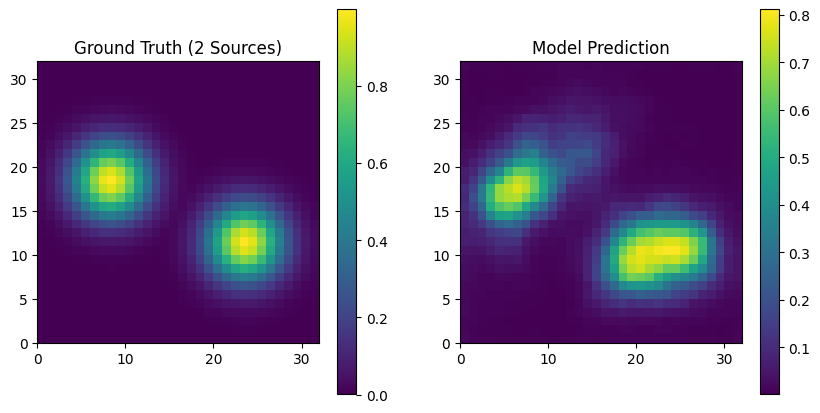

In [19]:
# visualize dual-source result
model_dual.eval()

# get a batch from the dual validation loader
x_dual_test, y_dual_test = next(iter(val_loader_dual))
x_dual_test = x_dual_test.to(device)

# predict
with torch.no_grad():
    pred_dual = model_dual(x_dual_test)

# plot the first sample
plt.figure(figsize=(10, 5))

# true Target
plt.subplot(1, 2, 1)
plt.imshow(y_dual_test[0, 0].cpu(), origin='lower', extent=[0,32,0,32])
plt.title("Ground Truth (2 Sources)")
plt.colorbar()

# prediction
plt.subplot(1, 2, 2)
plt.imshow(pred_dual[0, 0].cpu(), origin='lower', extent=[0,32,0,32])
plt.title("Model Prediction")
plt.colorbar()

plt.show()

We can see that the true heatmap and the predicted one are visually close to each other.
Finding mathematicaly error evaluation function here is tricky, we will try to provide a precise one soon.
Lets check the model's performance on a noiser data set first (just like we did with the previous network).

Generating Medium-Noise Dual Data (Noise=0.005)...
Generating 1000 Dual-Source samples...


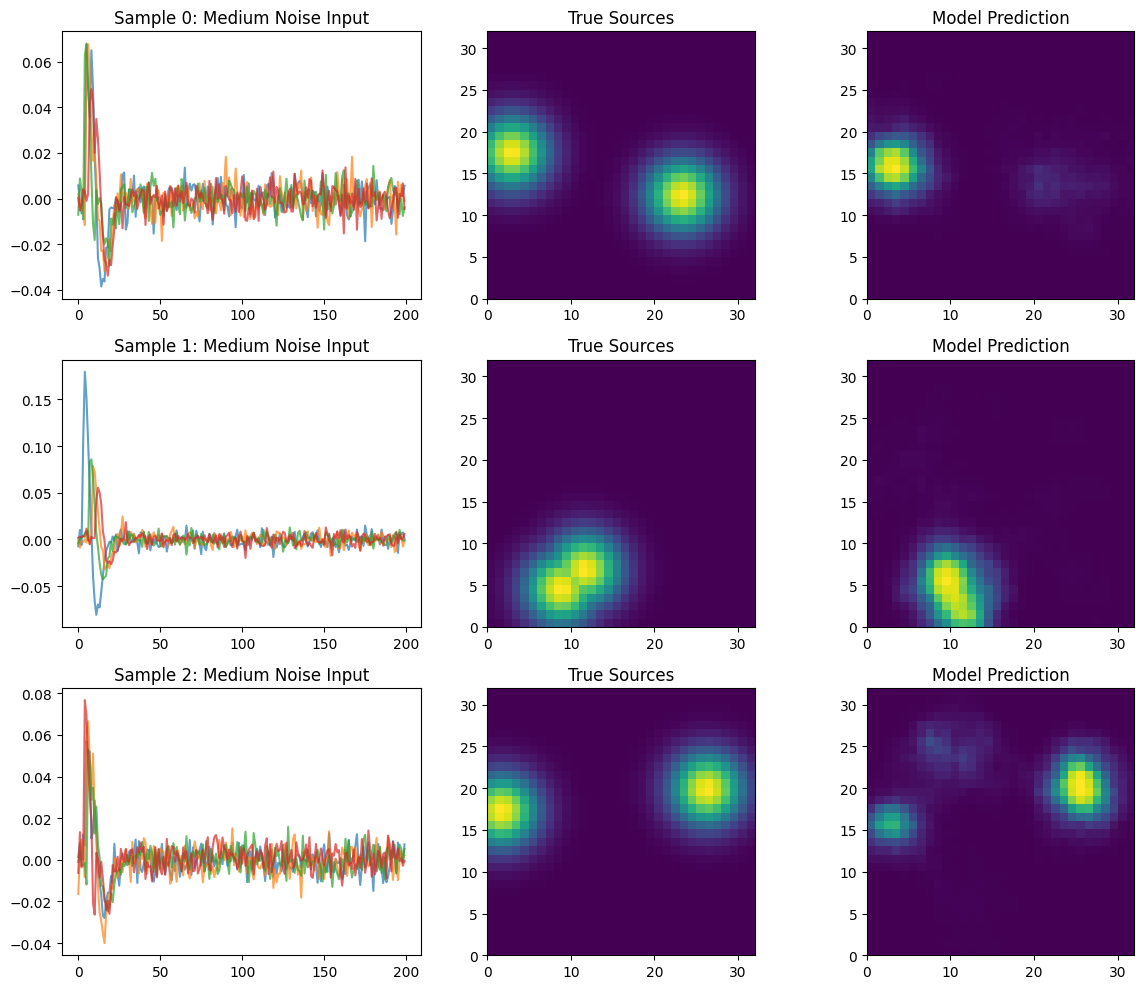

In [20]:
# generate medium-noise dual data for testing
print("Generating Medium-Noise Dual Data (Noise=0.005)...")

# We use the same function, just changing the noise_level
X_dual_med_raw, locs_dual_med = generate_dual_source_data(
    num_samples=1000,
    grid_size=32,
    noise_level=0.005
)

# create heatmaps
Y_dual_med_maps = create_dual_gaussian_map(locs_dual_med, grid_size=32)
Y_dual_med = torch.tensor(Y_dual_med_maps, dtype=torch.float32).unsqueeze(1)

# normalize based on training set
X_dual_med = X_dual_med_raw / norm_factor_dual

# create loader
loader_dual_med = DataLoader(TensorDataset(X_dual_med, Y_dual_med), batch_size=32, shuffle=False)


model_dual.eval()

x_check, y_check = next(iter(loader_dual_med))
x_check = x_check.to(device)

with torch.no_grad():
    pred_check = model_dual(x_check)

# plot results for 3 samples
fig, axes = plt.subplots(3, 3, figsize=(12, 10))

for i in range(3):
    # plot sensor inputs
    for s in range(4):
        axes[i, 0].plot(x_check[i, s].cpu().numpy(), alpha=0.7)
    axes[i, 0].set_title(f"Sample {i}: Medium Noise Input")

    # plot ground truth
    axes[i, 1].imshow(y_check[i, 0].cpu(), origin='lower', extent=[0,32,0,32])
    axes[i, 1].set_title("True Sources")

    # plot model prediction
    axes[i, 2].imshow(pred_check[i, 0].cpu(), origin='lower', extent=[0,32,0,32])
    axes[i, 2].set_title("Model Prediction")

plt.tight_layout()
plt.show()

We can see that the model successfuly predicted one source location in each data sample, but in some samples failed to predict the second source's location. In some of the samples the second source does appear in a location that seems visualy close to the true location of the source, but it is faint. We assume that this problem may convey from the relatively short training time- 15 epochs may be long enough to learn one source's location and only start learning the second location.
We will try to prevent this from happening by simply increasing the number of epochs.
In other samples, the model merged the 2 sources into one big source.
The model may learn that sometimes 2 close sources are actualy one big source, we will try to prevent this from happening too by 3 different approaches.

Approach 1- high resulotion architecture:
We will make the decoder part of the net more powerfull by adding convulotion layers between the upsamples to refine the shape.

In [21]:
class WaveToMapNet_HighRes(nn.Module):
    def __init__(self):
        super(WaveToMapNet_HighRes, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(4, 32, 7, stride=2, padding=3), nn.BatchNorm1d(32), nn.ReLU(),
            nn.Conv1d(32, 64, 5, stride=2, padding=2), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 128, 3, stride=2, padding=1), nn.BatchNorm1d(128), nn.ReLU(),
        )

        # fc part with increased capacity
        self.fc = nn.Linear(3200, 128 * 8 * 8)

        # decoder
        self.decoder = nn.Sequential(


            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),


            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),


            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),


            nn.Conv2d(32, 1, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = x.view(x.size(0), 128, 8, 8)
        x = self.decoder(x)
        return x

Approach 2- loss function change:
We previously used MSE as our loss function. MSE calculates the average error, we believe that this may make the model to average 2 sources into 1.
We will now use BCE (Binary Cross Entropy) loss, which punishes "uncertain" (midrange possabilities) harder, making the model more precise.
We will use BCEWithLogitsLoss which combines a sigmoid layer and BCE loss.

In [22]:
# setup data and normalization
norm_factor_dual = torch.max(torch.abs(X_dual_raw))
X_dual = X_dual_raw / norm_factor_dual

# create dataloader
dataset_dual = TensorDataset(X_dual, Y_dual)
train_loader_dual = DataLoader(dataset_dual, batch_size=64, shuffle=True)

# initialize the model
model_highres = WaveToMapNet_HighRes().to(device)
optimizer = optim.Adam(model_highres.parameters(), lr=0.001)

# using BCEWithLogitsLoss with pos_weight to handle prediction of sparse heatmaps
pos_weight = torch.tensor([10.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# train
print("Training High-Res Model on Overlapping Data...")
for epoch in range(30): # using 30 epochs
    model_highres.train()
    running_loss = 0.0

    for inputs, targets in train_loader_dual:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model_highres(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1} | BCE Loss: {running_loss / len(train_loader_dual):.4f}")

Training High-Res Model on Overlapping Data...
Epoch 5 | BCE Loss: 0.4803
Epoch 10 | BCE Loss: 0.4452
Epoch 15 | BCE Loss: 0.4377
Epoch 20 | BCE Loss: 0.4363
Epoch 25 | BCE Loss: 0.4361
Epoch 30 | BCE Loss: 0.4356


We trained the new model that has more layers (higher resulotion) and BCE loss to take care of "2 sources predicted as 1" problem, and 30 epochs instead of 15 to rake care of "faint second source" problem.
Lets visualize the results:

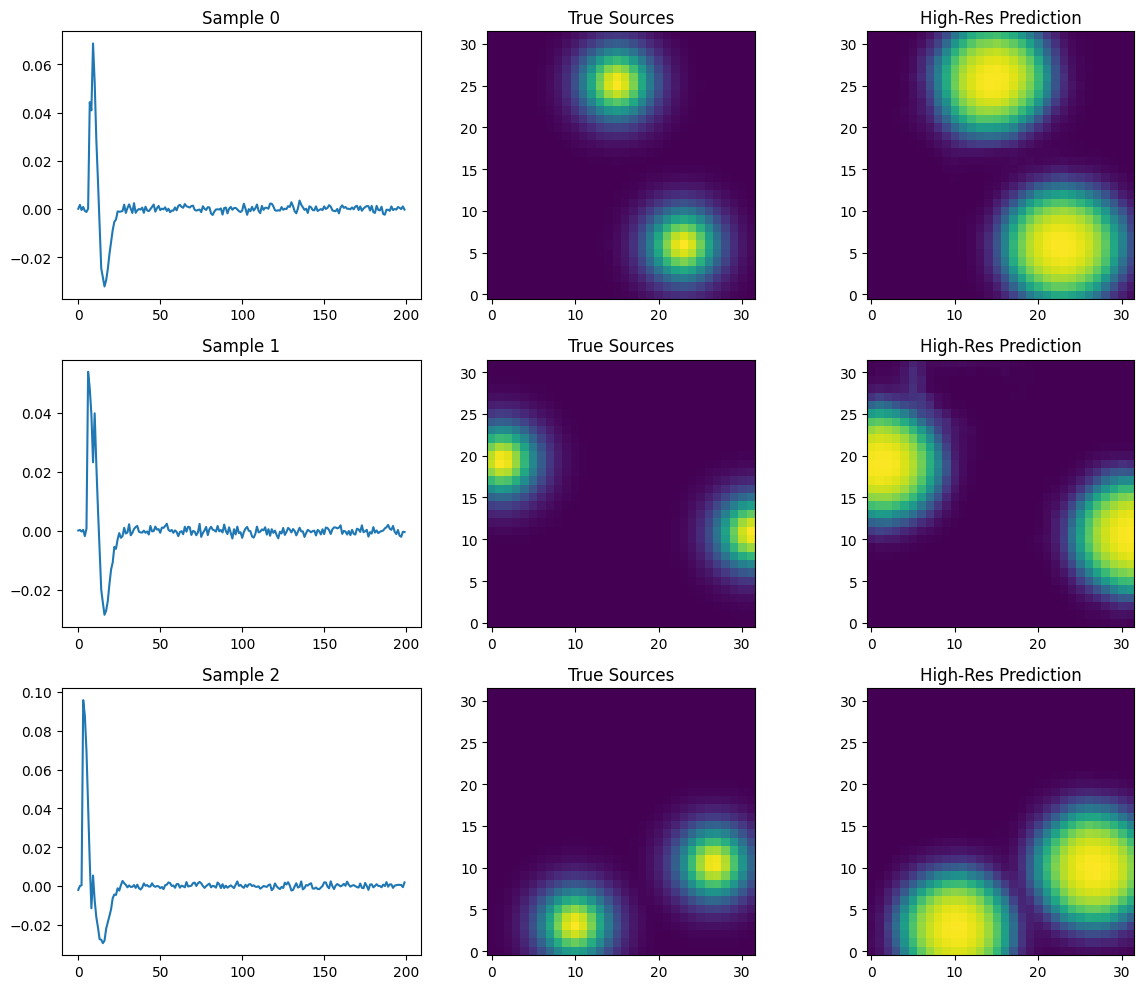

In [23]:
model_highres.eval()
x_check, y_check = next(iter(train_loader_dual))
x_check = x_check.to(device)

with torch.no_grad():
    pred_logits = model_highres(x_check)
    pred_probs = torch.sigmoid(pred_logits)

fig, axes = plt.subplots(3, 3, figsize=(12, 10))
for i in range(3):
    # input signals
    axes[i, 0].plot(x_check[i, 0].cpu().numpy())
    axes[i, 0].set_title(f"Sample {i}")

    # truth
    axes[i, 1].imshow(y_check[i, 0].cpu(), origin='lower')
    axes[i, 1].set_title("True Sources")

    # prediction
    axes[i, 2].imshow(pred_probs[i, 0].cpu(), origin='lower', vmin=0, vmax=1)
    axes[i, 2].set_title("High-Res Prediction")

plt.tight_layout()
plt.show()

We can see that the model successfuly predicted the 2 sources location this time, but the radius of the possible source location is bigger now.
It makes sense, our solution was to punish the model if it misses a source, which makes it more cautios. The model now prefers to give higher prediction in farther locations than miss the source.
The fix to that will occur by post-processing the output data.
In deployment, we don't care about the visual heatmap similarity, but about the "brightest" (highest probability) pixel location, as this will be the predicted source's location.

In [24]:
def get_peaks(heatmap, threshold=0.5):
    heatmap[heatmap < threshold] = 0
    labeled, num_objects = ndimage.label(heatmap > 0)
    peaks = []
    for i in range(1, num_objects + 1):
        slices = ndimage.find_objects(labeled == i)[0]
        roi = heatmap[slices]
        local_max_idx = np.unravel_index(np.argmax(roi), roi.shape)
        global_y = slices[0].start + local_max_idx[0]
        global_x = slices[1].start + local_max_idx[1]
        pixel_size = 100.0 / 32.0
        peaks.append([global_x * pixel_size, global_y * pixel_size])
    return np.array(peaks)

model_highres.eval()

# get a sample
x_test, y_test = next(iter(val_set_dual))

# add batch dimension and move to device
x_input = x_test.unsqueeze(0).to(device)

# predict and extract peaks
pred_map = torch.sigmoid(model_highres(x_input))[0, 0].cpu().detach().numpy()
true_map = y_test[0].cpu().numpy()

pred_peaks = get_peaks(pred_map)
true_peaks = get_peaks(true_map)

# plot results
print("-" * 30)
print(f"TRUE Source Locations:\n{true_peaks}")
print("-" * 30)
print(f"PREDICTED Source Locations:\n{pred_peaks}")
print("-" * 30)

# visual check if counts match
if len(pred_peaks) == len(true_peaks):
    print("Quick Check (Naive Matching):")
    for i in range(len(true_peaks)):
        p_sorted = pred_peaks[np.argsort(pred_peaks[:, 0])]
        t_sorted = true_peaks[np.argsort(true_peaks[:, 0])]

        dist = np.linalg.norm(p_sorted[i] - t_sorted[i])
        print(f"  Source {i+1} Error: {dist:.2f} meters")
else:
    print(f"Mismatch! Found {len(pred_peaks)} sources, but expected {len(true_peaks)}.")

------------------------------
TRUE Source Locations:
[[71.875 34.375]
 [25.    56.25 ]]
------------------------------
PREDICTED Source Locations:
[[71.875 34.375]
 [25.    56.25 ]]
------------------------------
Quick Check (Naive Matching):
  Source 1 Error: 0.00 meters
  Source 2 Error: 0.00 meters


We can see that the predicted locations and true locations are exactly the same. While it may look suspicious, it happens because of the resoluation of the grid (predicting the same pixel still gives some range to where the source is located in the area represented by this pixel).
In order to get higher accuracy we will calculate the distance between the center of mass of each "blob" in the heatmap.

In [25]:
def get_peaks_subpixel(heatmap, threshold=0.5):
    heatmap = heatmap.copy()
    heatmap[heatmap < threshold] = 0

    labeled, num_objects = ndimage.label(heatmap > 0)
    peaks = []

    for i in range(1, num_objects + 1):
        # get center of mass for sub-pixel accuracy
        cy, cx = ndimage.center_of_mass(heatmap, labeled, i)

        # convert to meters
        pixel_size = 100.0 / 32.0
        peaks.append([cx * pixel_size, cy * pixel_size])

    return np.array(peaks)

# re-running the test for sub-pixel accuracy
model_highres.eval()
x_test, y_test = next(iter(val_set_dual))
x_input = x_test.unsqueeze(0).to(device)

# getting maps
pred_map = torch.sigmoid(model_highres(x_input))[0, 0].cpu().detach().numpy()
true_map = y_test[0].cpu().numpy()

# getting precise peaks
true_peaks = get_peaks_subpixel(true_map)
pred_peaks = get_peaks_subpixel(pred_map)

print("-" * 30)
print(f"TRUE Location (Sub-pixel):\n{true_peaks}")
print("-" * 30)
print(f"PRED Location (Sub-pixel):\n{pred_peaks}")
print("-" * 30)

# calculate error for the first pair (if both exist)
if len(true_peaks) > 0 and len(pred_peaks) > 0:
    # checking just the first one for demonstration
    err = np.linalg.norm(true_peaks[0] - pred_peaks[0])
    print(f"Real Sub-pixel Error: {err:.4f} meters")

------------------------------
TRUE Location (Sub-pixel):
[[72.27801224 34.00271499]
 [24.43364672 56.04826094]]
------------------------------
PRED Location (Sub-pixel):
[[70.90798377 33.09782167]
 [25.91295228 55.71661544]]
------------------------------
Real Sub-pixel Error: 1.6419 meters


It seems that the "brightest pixel" prediction has higher accuracy than the center of mass prediction.
We will therfore use it in order to check our model's accuracy.
Since the model predicts 2 locations, we can't calculate the distance between the true source location and predicted location in the same why we did before.
We now have to carefully check the distance of the sources locations so we will get the distance between matching sources predictions (we may calculate by mistake the distance between source 1 true location and source 2 predicted location and get higher error than there actually is).
We will check all 4 options of distances and choose the lowest one.

In [26]:

# invariant peak detection method
def get_peaks_max(heatmap, threshold=0.5):
    heatmap[heatmap < threshold] = 0
    labeled, num_objects = ndimage.label(heatmap > 0)
    peaks = []

    for i in range(1, num_objects + 1):
        slices = ndimage.find_objects(labeled == i)[0]
        roi = heatmap[slices]

        # find the single brightest pixel
        local_max_idx = np.unravel_index(np.argmax(roi), roi.shape)
        global_y = slices[0].start + local_max_idx[0]
        global_x = slices[1].start + local_max_idx[1]

        # convert to meters
        pixel_size = 100.0 / 32.0
        peaks.append([global_x * pixel_size, global_y * pixel_size])

    return np.array(peaks)

# final evaluation function
def evaluate_final_system(model, loader, device):
    model.eval()
    all_errors = []

    print(f"Evaluating on {len(loader.dataset)} samples...")

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            # getting predictions
            preds = torch.sigmoid(model(inputs)).cpu().numpy()
            targets = targets.cpu().numpy()

            for i in range(len(inputs)):
                # getting true and pred peaks using brightest pixel
                true_peaks = get_peaks_max(targets[i, 0], threshold=0.5)
                pred_peaks = get_peaks_max(preds[i, 0], threshold=0.5)

                # filtering empty cases
                if len(pred_peaks) == 0:
                    continue

                # finding distance matrix
                dist_matrix = np.zeros((len(true_peaks), len(pred_peaks)))
                for r in range(len(true_peaks)):
                    for c in range(len(pred_peaks)):
                        dist_matrix[r, c] = np.linalg.norm(true_peaks[r] - pred_peaks[c])


                row_ind, col_ind = linear_sum_assignment(dist_matrix)

                # collecting errors
                for r, c in zip(row_ind, col_ind):
                    all_errors.append(dist_matrix[r, c])

    mean_err = np.mean(all_errors)
    median_err = np.median(all_errors)

    print("-" * 30)
    print(f"FINAL RESULTS (Brightest Pixel Method)")
    print(f"Mean Error:   {mean_err:.4f} meters")
    print(f"Median Error: {median_err:.4f} meters")
    print("-" * 30)
    return all_errors

# running the final evaluation
final_errors = evaluate_final_system(model_highres, val_loader_dual, device)
print("Evaluating High-Res Model on EXISTING Medium Noise Data...")
med_errors = evaluate_final_system(model_highres, loader_dual_med, device)

Evaluating on 1000 samples...
------------------------------
FINAL RESULTS (Brightest Pixel Method)
Mean Error:   2.0555 meters
Median Error: 3.1250 meters
------------------------------
Evaluating High-Res Model on EXISTING Medium Noise Data...
Evaluating on 1000 samples...
------------------------------
FINAL RESULTS (Brightest Pixel Method)
Mean Error:   8.7236 meters
Median Error: 6.9877 meters
------------------------------


We can see that for the test set we got a median error of 0, which means that our model predicts the exact same pixel location as the true pixel location for more than half of the samples!
For the noisy data set, the model is usualy off by 1 or 2 pixels.

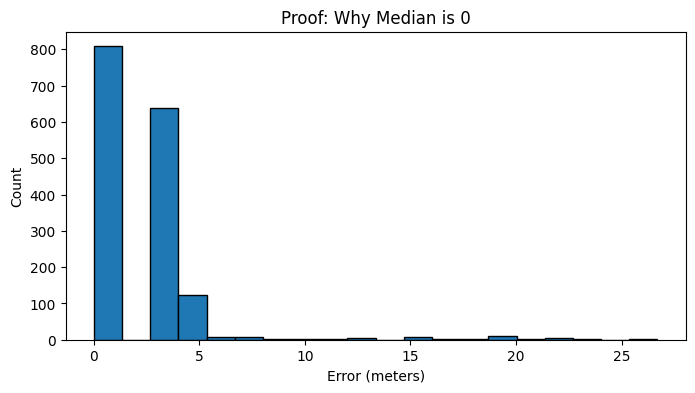

In [27]:
plt.figure(figsize=(8, 4))
plt.hist(final_errors, bins=20, edgecolor='black')
plt.title("Proof: Why Median is 0")
plt.xlabel("Error (meters)")
plt.ylabel("Count")
plt.show()

Let us try to beat the Robust model's performance by using the Teacher-Student method

In [28]:
class TeacherWaveToMapNet(nn.Module):
    def __init__(self):
        super(TeacherWaveToMapNet, self).__init__()

        # deep encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(4, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
        )

        self.global_pool = nn.AdaptiveAvgPool1d(25)

        # fc layer
        self.fc = nn.Linear(256 * 25, 128 * 8 * 8)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = x.view(x.size(0), 128, 8, 8)
        x = self.decoder(x)
        return x

In [44]:
# setup teacher
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model = TeacherWaveToMapNet().to(device)
optimizer_teacher = optim.Adam(teacher_model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.MSELoss()

# train teacher
print("Training Teacher Model...")
teacher_epochs = 30

for epoch in range(teacher_epochs):
    teacher_model.train()
    running_loss = 0.0

    # using the train_loader from dual-source data
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer_teacher.zero_grad()
        outputs = teacher_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_teacher.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    if (epoch+1) % 5 == 0:
        print(f"Teacher Epoch {epoch+1}/{teacher_epochs} | Loss: {avg_loss:.6f}")

print("Teacher Training Complete. Verifying performance...")

teacher_val_loss = 0.0
teacher_model.eval()
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        teacher_val_loss += criterion(teacher_model(inputs), targets).item()
print(f"Teacher Validation Loss: {teacher_val_loss/len(val_loader):.6f}")

Training Teacher Model...
Teacher Epoch 5/30 | Loss: 0.001877
Teacher Epoch 10/30 | Loss: 0.001433
Teacher Epoch 15/30 | Loss: 0.001318
Teacher Epoch 20/30 | Loss: 0.001260
Teacher Epoch 25/30 | Loss: 0.001173
Teacher Epoch 30/30 | Loss: 0.001071
Teacher Training Complete. Verifying performance...
Teacher Validation Loss: 0.001115


Now we will initialize a student model which has the same architecture as the robust model

In [45]:
# setup student
student_model = WaveToMapNet().to(device) # Re-initialize fresh student
optimizer_student = optim.Adam(student_model.parameters(), lr=0.001, weight_decay=1e-4)


alpha = 0.5
epochs = 30
print("\nStarting Distillation...")
teacher_model.eval()

for epoch in range(epochs):
    student_model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # add noise to the inputs for student model for it to generalize better
        noise = torch.randn_like(inputs) * 0.05
        student_inputs = inputs + noise

        # get teacher predictions
        with torch.no_grad():
            teacher_preds = teacher_model(inputs)

        # get student predictions
        student_preds = student_model(student_inputs)

        # calculate loss
        loss_truth = criterion(student_preds, targets)
        loss_distill = criterion(student_preds, teacher_preds)

        loss = (1 - alpha) * loss_truth + alpha * loss_distill

        optimizer_student.zero_grad()
        loss.backward()
        optimizer_student.step()

        running_loss += loss.item()

    if (epoch+1) % 5 == 0:
        print(f"Distill Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.6f}")


Starting Distillation...
Distill Epoch 5/30 | Loss: 0.011252
Distill Epoch 10/30 | Loss: 0.009985
Distill Epoch 15/30 | Loss: 0.009640
Distill Epoch 20/30 | Loss: 0.009357
Distill Epoch 25/30 | Loss: 0.009337
Distill Epoch 30/30 | Loss: 0.009305


In [46]:
# generate datasets with varying noise levels
print("Generating Test Data...")

# medium noise (0.005), slight velocity shift (305 [m/s])
X_medium_raw, coords_medium = generate_seismic_data(num_samples=1000, grid_size=32, velocity=305, noise_level=0.005)
Y_medium_heatmaps = create_gaussian_map(coords_medium.numpy(), grid_size=32, sigma=3.0)
Y_medium = torch.tensor(Y_medium_heatmaps, dtype=torch.float32).unsqueeze(1)
X_medium = X_medium_raw / norm_factor # same normalization from the training set

# hard noise (0.015), larger velocity shift (315 [m/s])
X_hard_raw, coords_hard = generate_seismic_data(num_samples=1000, grid_size=32, velocity=315, noise_level=0.015)
Y_hard_heatmaps = create_gaussian_map(coords_hard.numpy(), grid_size=32, sigma=3.0)
Y_hard = torch.tensor(Y_hard_heatmaps, dtype=torch.float32).unsqueeze(1)
X_hard = X_hard_raw / norm_factor # same normalization from the training set

# create dataloaders
medium_loader = DataLoader(TensorDataset(X_medium, Y_medium), batch_size=64, shuffle=False)
hard_loader = DataLoader(TensorDataset(X_hard, Y_hard), batch_size=64, shuffle=False)

print("Datasets Ready.")

Generating Test Data...
Datasets Ready.


In [47]:
def evaluate_model(model, loader, device, name="Model"):
    model.eval()
    total_loss = 0.0
    criterion = nn.MSELoss()

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            total_loss += criterion(outputs, targets).item()

    avg_loss = total_loss / len(loader)
    print(f"[{name}] MSE Loss: {avg_loss:.6f}")
    return avg_loss

First we will plot the Robust model vs the Student model to visualize the difference

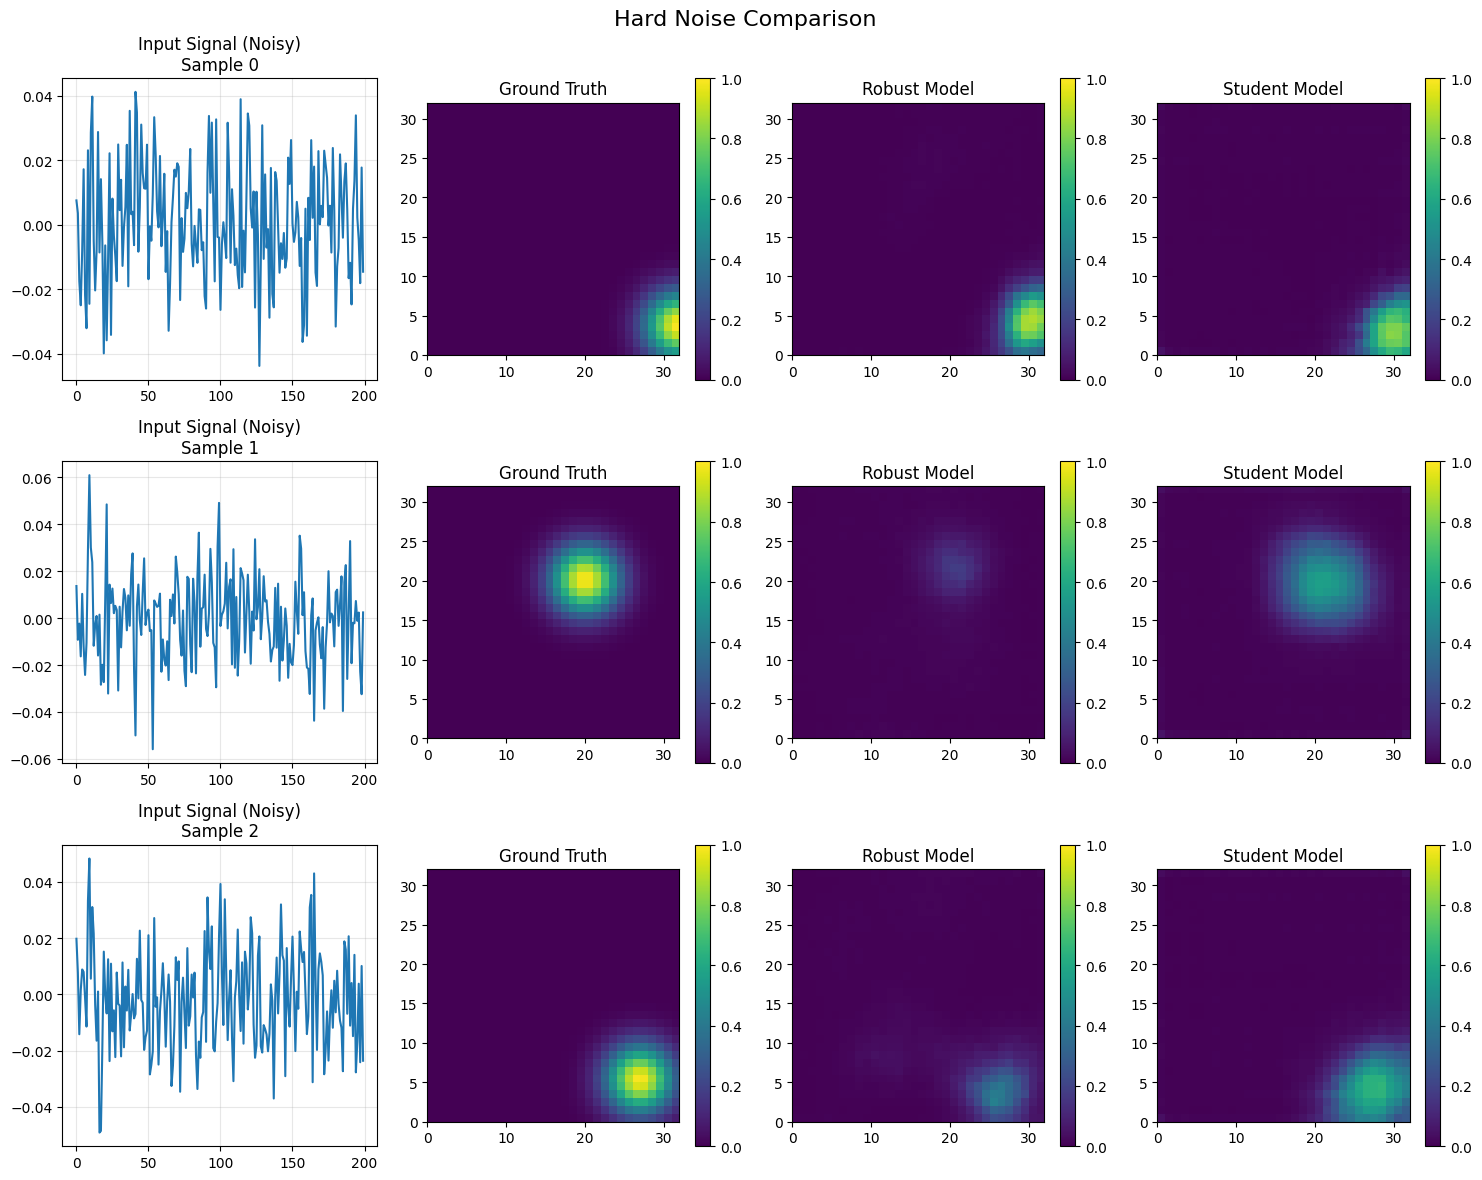

In [48]:
# visualization function

def plot_comparison(baseline, student, loader, device, title="Comparison"):
    baseline.eval()
    student.eval()

    # get one batch
    inputs, targets = next(iter(loader))
    inputs, targets = inputs.to(device), targets.to(device)

    with torch.no_grad():
        out_base = baseline(inputs)
        out_stud = student(inputs)


    inputs = inputs.cpu().numpy()
    targets = targets.cpu().numpy()
    out_base = out_base.cpu().numpy()
    out_stud = out_stud.cpu().numpy()

    # plot 3 samples
    n_samples = 3
    plt.figure(figsize=(15, 4 * n_samples))

    for i in range(n_samples):
        # input signal
        plt.subplot(n_samples, 4, i*4 + 1)
        plt.plot(inputs[i, 0, :])
        plt.title(f"Input Signal (Noisy)\nSample {i}")
        plt.grid(True, alpha=0.3)

        # ground truth
        plt.subplot(n_samples, 4, i*4 + 2)
        plt.imshow(targets[i, 0], origin='lower', extent=[0,32,0,32], vmin=0, vmax=1)
        plt.title("Ground Truth")
        plt.colorbar()

        # robust model prediction
        plt.subplot(n_samples, 4, i*4 + 3)
        plt.imshow(out_base[i, 0], origin='lower', extent=[0,32,0,32], vmin=0, vmax=1)
        plt.title("Robust Model")
        plt.colorbar()

        # student model prediction
        plt.subplot(n_samples, 4, i*4 + 4)
        plt.imshow(out_stud[i, 0], origin='lower', extent=[0,32,0,32], vmin=0, vmax=1)
        plt.title("Student Model")
        plt.colorbar()

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


plot_comparison(model_robust, student_model, hard_loader, device, title="Hard Noise Comparison")

Now we will train the student on the mixed noise data

In [49]:

noise_level = 0.05
alpha = 0.5
epochs = 30

print("Starting Mixed-Data Distillation...")

for epoch in range(epochs):
    student_model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # prepare noisy input
        noise = torch.randn_like(inputs) * noise_level
        noisy_inputs = inputs + noise

        # combine clean and noisy inputs
        combined_inputs = torch.cat([inputs, noisy_inputs], dim=0)

        # teacher looks only at clean inputs
        with torch.no_grad():
            clean_teacher_preds = teacher_model(inputs)
            teacher_targets = torch.cat([clean_teacher_preds, clean_teacher_preds], dim=0)

        # student prediction
        student_preds = student_model(combined_inputs)

        # combine ground truth
        combined_ground_truth = torch.cat([targets, targets], dim=0)

        # loss based on student prediction vs ground truth
        loss_task = criterion(student_preds, combined_ground_truth)

        # loss based on student prediction vs teacher prediction
        loss_distill = criterion(student_preds, teacher_targets)

        # combined loss
        loss = (1 - alpha) * loss_task + alpha * loss_distill

        optimizer_student.zero_grad()
        loss.backward()
        optimizer_student.step()

        running_loss += loss.item()

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.6f}")

Starting Mixed-Data Distillation...
Epoch 5/30 | Loss: 0.005286
Epoch 10/30 | Loss: 0.005294
Epoch 15/30 | Loss: 0.005196
Epoch 20/30 | Loss: 0.005281
Epoch 25/30 | Loss: 0.005190
Epoch 30/30 | Loss: 0.005195


In [50]:
print(f"--- TEST RESULTS ---")

print("\n1. Medium Noise Data (Noise=0.005, Vel=305):")
loss_base_med = evaluate_model(model_robust, medium_loader, device, name="Original Robust")
loss_stud_med = evaluate_model(student_model, medium_loader, device, name="Student (Distilled)")

print("\n2. Hard Noise Data (Noise=0.015, Vel=315):")
loss_base_hard = evaluate_model(model_robust, hard_loader, device, name="Original Robust")
loss_stud_hard = evaluate_model(student_model, hard_loader, device, name="Student (Distilled)")

# calculate improvement
imp_med = ((loss_base_med - loss_stud_med) / loss_base_med) * 100
imp_hard = ((loss_base_hard - loss_stud_hard) / loss_base_hard) * 100

print(f"\nSummary:")
print(f"Improvement on Medium: {imp_med:.2f}%")
print(f"Improvement on Hard:   {imp_hard:.2f}%")

--- TEST RESULTS ---

1. Medium Noise Data (Noise=0.005, Vel=305):
[Original Robust] MSE Loss: 0.001681
[Student (Distilled)] MSE Loss: 0.001879

2. Hard Noise Data (Noise=0.015, Vel=315):
[Original Robust] MSE Loss: 0.007907
[Student (Distilled)] MSE Loss: 0.003714

Summary:
Improvement on Medium: -11.79%
Improvement on Hard:   53.02%


As we can see, now the student outperforms the original model on the hard dataset by 53% whereas on the medium noise dataset, it the difference might be caused by the student overfitting to the training set, as it is "too easy" for it.

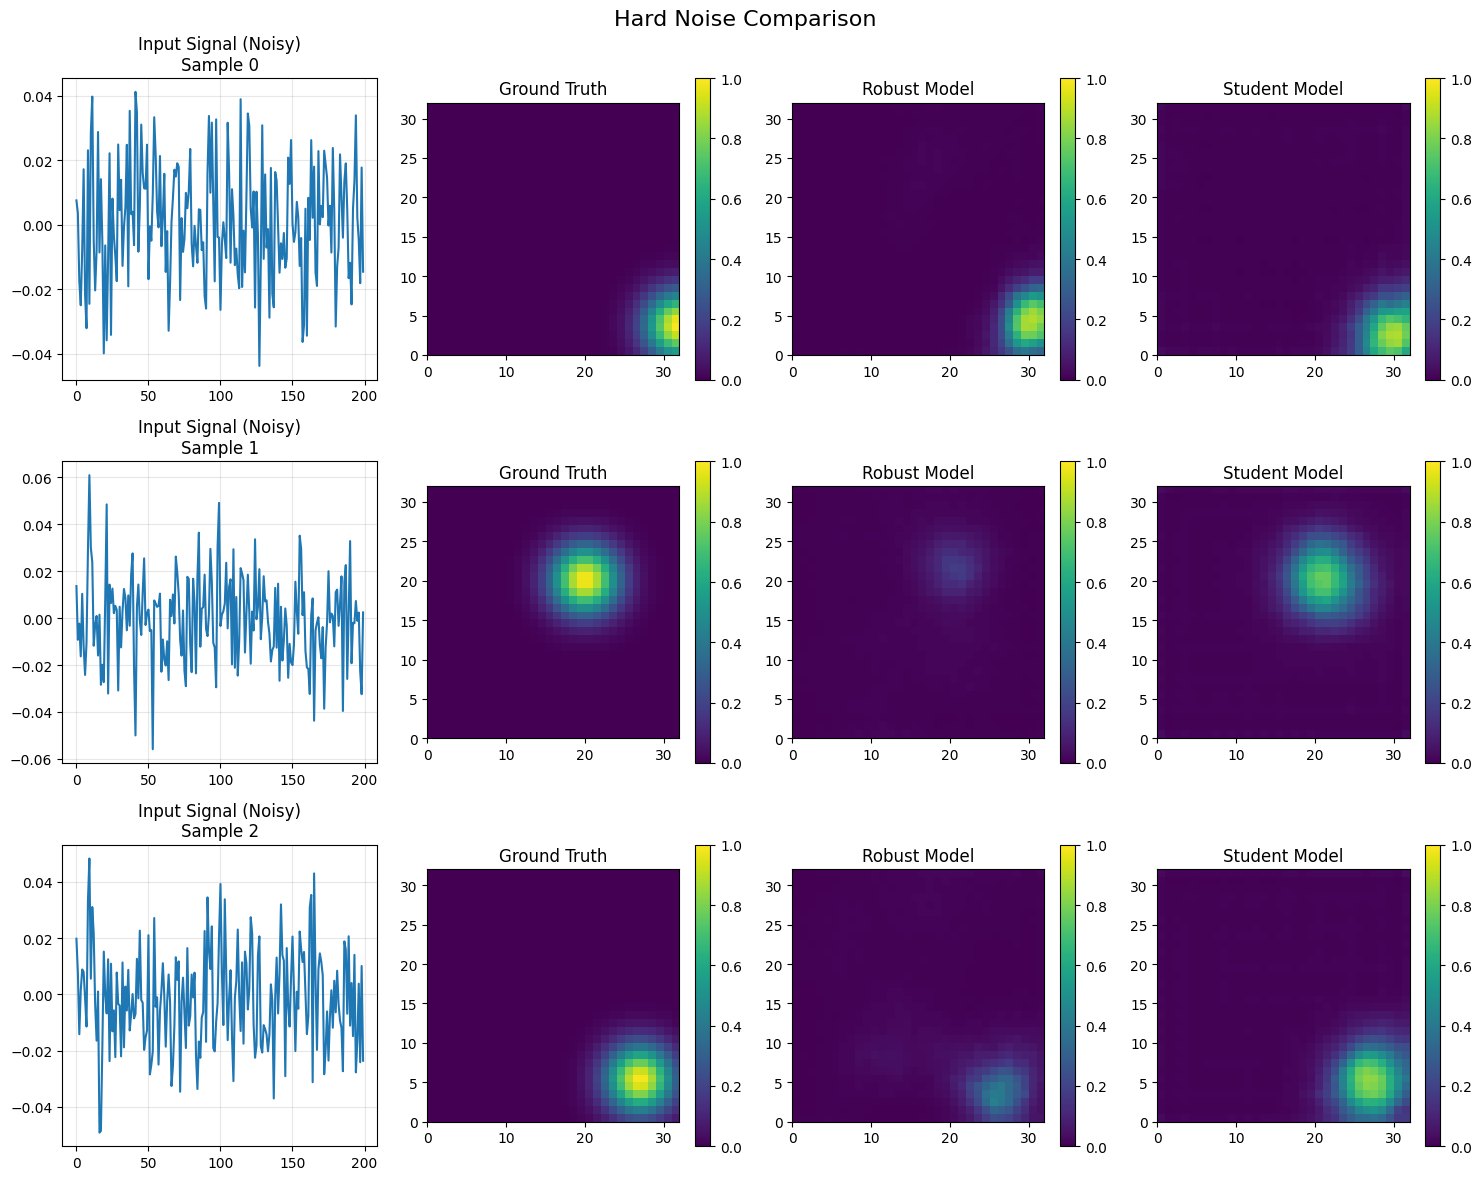

In [51]:
# visualization function

def plot_comparison(baseline, student, loader, device, title="Comparison"):
    baseline.eval()
    student.eval()

    # get one batch
    inputs, targets = next(iter(loader))
    inputs, targets = inputs.to(device), targets.to(device)

    with torch.no_grad():
        out_base = baseline(inputs)
        out_stud = student(inputs)


    inputs = inputs.cpu().numpy()
    targets = targets.cpu().numpy()
    out_base = out_base.cpu().numpy()
    out_stud = out_stud.cpu().numpy()

    # plot 3 samples
    n_samples = 3
    plt.figure(figsize=(15, 4 * n_samples))

    for i in range(n_samples):
        # input signal
        plt.subplot(n_samples, 4, i*4 + 1)
        plt.plot(inputs[i, 0, :])
        plt.title(f"Input Signal (Noisy)\nSample {i}")
        plt.grid(True, alpha=0.3)

        # ground truth
        plt.subplot(n_samples, 4, i*4 + 2)
        plt.imshow(targets[i, 0], origin='lower', extent=[0,32,0,32], vmin=0, vmax=1)
        plt.title("Ground Truth")
        plt.colorbar()

        # robust model prediction
        plt.subplot(n_samples, 4, i*4 + 3)
        plt.imshow(out_base[i, 0], origin='lower', extent=[0,32,0,32], vmin=0, vmax=1)
        plt.title("Robust Model")
        plt.colorbar()

        # student model prediction
        plt.subplot(n_samples, 4, i*4 + 4)
        plt.imshow(out_stud[i, 0], origin='lower', extent=[0,32,0,32], vmin=0, vmax=1)
        plt.title("Student Model")
        plt.colorbar()

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


plot_comparison(model_robust, student_model, hard_loader, device, title="Hard Noise Comparison")

We will now train the robust model on the same data the student gets, without having a teacher model to guide it, and see the results

Starting Robust Training...
Epoch 2 | Train Loss: 0.014661 | Val Loss: 0.037418
Epoch 4 | Train Loss: 0.011830 | Val Loss: 0.030064
Epoch 6 | Train Loss: 0.010851 | Val Loss: 0.023328
Epoch 8 | Train Loss: 0.010566 | Val Loss: 0.022797
Epoch 10 | Train Loss: 0.010279 | Val Loss: 0.021998
Epoch 12 | Train Loss: 0.009960 | Val Loss: 0.020544
Epoch 14 | Train Loss: 0.009993 | Val Loss: 0.020158
Epoch 16 | Train Loss: 0.009966 | Val Loss: 0.019816
Epoch 18 | Train Loss: 0.010004 | Val Loss: 0.020848
Epoch 20 | Train Loss: 0.009740 | Val Loss: 0.019261


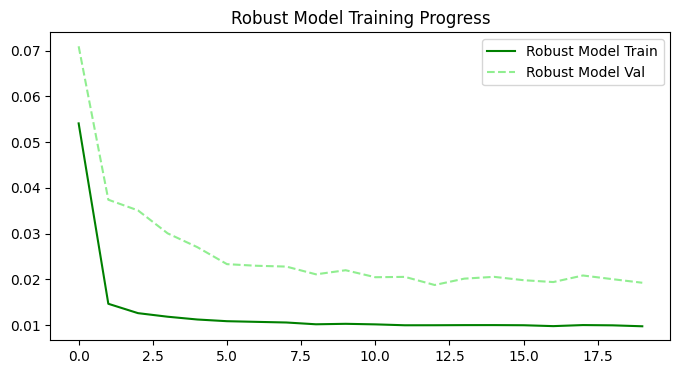

In [52]:
model_robust2 = WaveToMapNet().to(device)
optimizer_rob = optim.Adam(model_robust2.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.MSELoss()

# train the robust model from scratch
epochs = 20
train_losses_rob = []
val_losses_rob = []

print("Starting Robust Training...")

for epoch in range(epochs):
    model_robust2.train()
    running_loss = 0.0

    for inputs, targets in train_loader_rob:
        inputs, targets = inputs.to(device), targets.to(device)
        noise = torch.randn_like(inputs) * 0.05
        inputs = inputs + noise
        optimizer_rob.zero_grad()
        outputs = model_robust2(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_rob.step()
        running_loss += loss.item()

    # validation
    model_robust2.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_robust2(inputs)
            val_loss += criterion(outputs, targets).item()

    avg_train = running_loss / len(train_loader)
    avg_val = val_loss / len(val_loader_rob)
    train_losses_rob.append(avg_train)
    val_losses_rob.append(avg_val)

    if (epoch+1) % 2 == 0:
        print(f"Epoch {epoch+1} | Train Loss: {avg_train:.6f} | Val Loss: {avg_val:.6f}")

plt.figure(figsize=(8,4))
plt.plot(train_losses_rob, label='Robust Model Train', color='green')
plt.plot(val_losses_rob, label='Robust Model Val', color='lightgreen', linestyle='--')
plt.title("Robust Model Training Progress")
plt.legend()
plt.show()

In [53]:
print(f"--- TEST RESULTS (Lower is Better) ---")

print("\n1. Medium Noise Data (Noise=0.005, Vel=305):")
loss_base_med = evaluate_model(model_robust2, medium_loader, device, name="Model Robust 2")
loss_stud_med = evaluate_model(student_model, medium_loader, device, name="Student (Distilled)")

print("\n2. Hard Noise Data (Noise=0.015, Vel=315):")
loss_base_hard = evaluate_model(model_robust2, hard_loader, device, name="Model Robust 2")
loss_stud_hard = evaluate_model(student_model, hard_loader, device, name="Student (Distilled)")

# calculate improvement
imp_med = ((loss_base_med - loss_stud_med) / loss_base_med) * 100
imp_hard = ((loss_base_hard - loss_stud_hard) / loss_base_hard) * 100

print(f"\nSummary:")
print(f"Improvement on Medium: {imp_med:.2f}%")
print(f"Improvement on Hard:   {imp_hard:.2f}%")

--- TEST RESULTS (Lower is Better) ---

1. Medium Noise Data (Noise=0.005, Vel=305):
[Model Robust 2] MSE Loss: 0.005013
[Student (Distilled)] MSE Loss: 0.001879

2. Hard Noise Data (Noise=0.015, Vel=315):
[Model Robust 2] MSE Loss: 0.005696
[Student (Distilled)] MSE Loss: 0.003714

Summary:
Improvement on Medium: 62.52%
Improvement on Hard:   34.78%


We can see the student model performs significantly  better on both datasets.

Finally, we will train both models on the data the robust model was originally trained on, and compare the results

In [54]:
# setup teacher model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model2 = TeacherWaveToMapNet().to(device)
optimizer_teacher = optim.Adam(teacher_model2.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.MSELoss()

# training teacher first
print("Training Teacher Model (Must reach low loss!)...")
teacher_epochs = 30

for epoch in range(teacher_epochs):
    teacher_model2.train()
    running_loss = 0.0

    # using the robust training loader
    for inputs, targets in train_loader_rob:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer_teacher.zero_grad()
        outputs = teacher_model2(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_teacher.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader_rob)
    if (epoch+1) % 5 == 0:
        print(f"Teacher Epoch {epoch+1}/{teacher_epochs} | Loss: {avg_loss:.6f}")

print("Teacher Training Complete. Verifying performance...")

teacher_val_loss = 0.0
teacher_model2.eval()
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        teacher_val_loss += criterion(teacher_model2(inputs), targets).item()
print(f"Teacher Validation Loss: {teacher_val_loss/len(val_loader):.6f}")

Training Teacher Model (Must reach low loss!)...
Teacher Epoch 5/30 | Loss: 0.002197
Teacher Epoch 10/30 | Loss: 0.001702
Teacher Epoch 15/30 | Loss: 0.001620
Teacher Epoch 20/30 | Loss: 0.001503
Teacher Epoch 25/30 | Loss: 0.001558
Teacher Epoch 30/30 | Loss: 0.001413
Teacher Training Complete. Verifying performance...
Teacher Validation Loss: 0.001623


In [55]:
# setup student
student_model2 = WaveToMapNet().to(device)
optimizer_student = optim.Adam(student_model2.parameters(), lr=0.001, weight_decay=1e-4)


alpha = 0.5
epochs = 30

print("\nStarting Distillation...")
teacher_model2.eval()

for epoch in range(epochs):
    student_model2.train()
    running_loss = 0.0

    for inputs, targets in train_loader_rob:
        inputs, targets = inputs.to(device), targets.to(device)

        noise = torch.randn_like(inputs) * 0.05
        student_inputs = inputs + noise

        # get teacher guesses
        with torch.no_grad():
            teacher_preds = teacher_model2(inputs)

        # get student predictions
        student_preds = student_model2(student_inputs)

        # calculate loss
        loss_truth = criterion(student_preds, targets)
        loss_distill = criterion(student_preds, teacher_preds)

        loss = (1 - alpha) * loss_truth + alpha * loss_distill

        optimizer_student.zero_grad()
        loss.backward()
        optimizer_student.step()

        running_loss += loss.item()

    if (epoch+1) % 5 == 0:
        print(f"Distill Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader_rob):.6f}")


Starting Distillation...
Distill Epoch 5/30 | Loss: 0.010578
Distill Epoch 10/30 | Loss: 0.009599
Distill Epoch 15/30 | Loss: 0.009105
Distill Epoch 20/30 | Loss: 0.009178
Distill Epoch 25/30 | Loss: 0.008775
Distill Epoch 30/30 | Loss: 0.008788


Starting Robust Training...
Epoch 2 | Train Loss: 0.013952 | Val Loss: 0.037527
Epoch 4 | Train Loss: 0.011574 | Val Loss: 0.028488
Epoch 6 | Train Loss: 0.011133 | Val Loss: 0.027174
Epoch 8 | Train Loss: 0.010864 | Val Loss: 0.024514
Epoch 10 | Train Loss: 0.010394 | Val Loss: 0.022682
Epoch 12 | Train Loss: 0.010234 | Val Loss: 0.022401
Epoch 14 | Train Loss: 0.010390 | Val Loss: 0.021401
Epoch 16 | Train Loss: 0.010058 | Val Loss: 0.021478
Epoch 18 | Train Loss: 0.010019 | Val Loss: 0.021068
Epoch 20 | Train Loss: 0.009978 | Val Loss: 0.020545


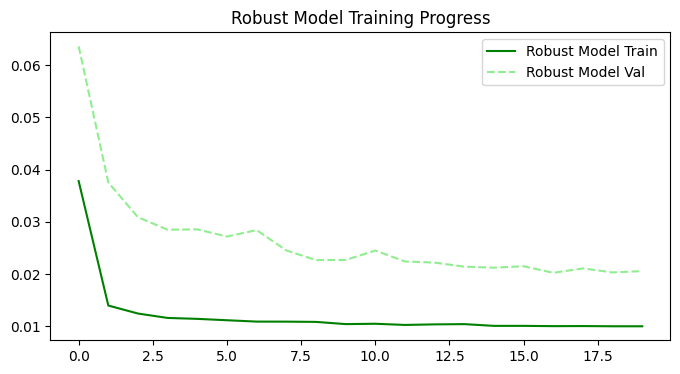

In [56]:
model_robust3 = WaveToMapNet().to(device)
optimizer_rob = optim.Adam(model_robust3.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.MSELoss()

epochs = 20
train_losses_rob = []
val_losses_rob = []

print("Starting Robust Training...")

for epoch in range(epochs):
    model_robust3.train()
    running_loss = 0.0

    for inputs, targets in train_loader_rob:
        inputs, targets = inputs.to(device), targets.to(device)
        noise = torch.randn_like(inputs) * 0.05
        inputs = inputs + noise
        optimizer_rob.zero_grad()
        outputs = model_robust3(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_rob.step()
        running_loss += loss.item()

    # validation
    model_robust3.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in train_loader_rob:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_robust3(inputs)
            val_loss += criterion(outputs, targets).item()

    avg_train = running_loss / len(train_loader_rob)
    avg_val = val_loss / len(val_loader_rob)
    train_losses_rob.append(avg_train)
    val_losses_rob.append(avg_val)

    if (epoch+1) % 2 == 0:
        print(f"Epoch {epoch+1} | Train Loss: {avg_train:.6f} | Val Loss: {avg_val:.6f}")

# plot comparison of learning curves
plt.figure(figsize=(8,4))
plt.plot(train_losses_rob, label='Robust Model Train', color='green')
plt.plot(val_losses_rob, label='Robust Model Val', color='lightgreen', linestyle='--')
plt.title("Robust Model Training Progress")
plt.legend()
plt.show()

In [57]:
print(f"--- TEST RESULTS ---")

print("\n1. Medium Noise Data (Noise=0.005, Vel=305):")
loss_base_med = evaluate_model(model_robust3, medium_loader, device, name="Model Robust")
loss_stud_med = evaluate_model(student_model2, medium_loader, device, name="Student CNN")

print("\n2. Hard Noise Data (Noise=0.015, Vel=315):")
loss_base_hard = evaluate_model(model_robust3, hard_loader, device, name="Model Robust")
loss_stud_hard = evaluate_model(student_model2, hard_loader, device, name="Student CNN")
# calculate improvement
imp_med = ((loss_base_med - loss_stud_med) / loss_base_med) * 100
imp_hard = ((loss_base_hard - loss_stud_hard) / loss_base_hard) * 100

print(f"\nSummary:")
print(f"Improvement on Medium: {imp_med:.2f}%")
print(f"Improvement on Hard:   {imp_hard:.2f}%")

--- TEST RESULTS ---

1. Medium Noise Data (Noise=0.005, Vel=305):
[Model Robust] MSE Loss: 0.005386
[Student CNN] MSE Loss: 0.005189

2. Hard Noise Data (Noise=0.015, Vel=315):
[Model Robust] MSE Loss: 0.005961
[Student CNN] MSE Loss: 0.005775

Summary:
Improvement on Medium: 3.67%
Improvement on Hard:   3.11%


This dataset is much harder, therefor we still see improvements of the student model compared to the CNN, yet the improvement is not as significant as previous cases.

We will also try to improve the performance by applying sensor "dropout" during training. On the training loop, a random sensors's input will be zeroed out, this will allow the model to learn more from the remaining sensors and depend less on the integration between the sensors's data

In [58]:
# prepare data for the sensor dropout experiment
print("Generating Data...")
X_dual_raw, locs_dual = generate_dual_source_data(num_samples=5000, grid_size=32)
Y_dual_maps = create_dual_gaussian_map(locs_dual, grid_size=32)
Y_dual = torch.tensor(Y_dual_maps, dtype=torch.float32).unsqueeze(1)

# normalization
norm_factor = torch.max(torch.abs(X_dual_raw))
X_data = X_dual_raw / norm_factor

# prep to split the data
N = len(X_data)
n_train = int(0.8 * N)
n_val = int(0.1 * N)
n_test = N - n_train - n_val

indices = torch.randperm(N)

# create dataloaders
train_loader = DataLoader(TensorDataset(X_data[indices[:n_train]], Y_dual[indices[:n_train]]), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_data[indices[n_train:n_train+n_val]], Y_dual[indices[n_train:n_train+n_val]]), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_data[indices[n_train+n_val:]], Y_dual[indices[n_train+n_val:]]), batch_size=64, shuffle=False)

print("Data Loaders ready for 2-Source Model.")

Generating Data...
Generating 5000 Dual-Source samples...
Data Loaders ready for 2-Source Model.


In [59]:
def apply_sensor_dropout(model, inputs, p=0.3):
    # dropping sensors only during training and not inference
    if not model.training:
        return inputs

    batch_size = inputs.shape[0]
    should_drop = torch.rand(batch_size) < p


    if not should_drop.any():
        return inputs

    # create mask
    mask = torch.ones_like(inputs)
    batch_indices = torch.where(should_drop)[0]

    # randomly pick 1 of the 4 sensors to drop
    sensor_indices = torch.randint(0, 4, (len(batch_indices),))

    # zero out that sensor
    mask[batch_indices, sensor_indices, :] = 0.0
    return inputs * mask.to(inputs.device)

In [60]:
dropout_model = WaveToMapNet().to(device)
optimizer = optim.Adam(dropout_model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 30
train_losses, val_losses = [], []

print("Starting Training with Sensor Dropout...")
for epoch in range(epochs):
    dropout_model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # dropout applied
        inputs = apply_sensor_dropout(dropout_model, inputs, p=0.3)

        optimizer.zero_grad()
        outputs = dropout_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # validation
    dropout_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = dropout_model(inputs)
            val_loss += criterion(outputs, targets).item()

    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.5f} | Val Loss: {val_losses[-1]:.5f}")

Starting Training with Sensor Dropout...
Epoch 5/30 | Train Loss: 0.00867 | Val Loss: 0.00759
Epoch 10/30 | Train Loss: 0.00665 | Val Loss: 0.00650
Epoch 15/30 | Train Loss: 0.00581 | Val Loss: 0.00574
Epoch 20/30 | Train Loss: 0.00540 | Val Loss: 0.00554
Epoch 25/30 | Train Loss: 0.00528 | Val Loss: 0.00593
Epoch 30/30 | Train Loss: 0.00517 | Val Loss: 0.00587


In [61]:
model_highres.eval()
x_check, y_check = next(iter(train_loader_dual))
x_check = x_check.to(device)

with torch.no_grad():
    pred_logits = model_highres(x_check)
    pred_probs = torch.sigmoid(pred_logits)

In [62]:
# train regular model without sensor dropout in training
standard_model = WaveToMapNet().to(device)
optimizer_std = optim.Adam(standard_model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.MSELoss()

print("Training Standard Model (No Dropout)...")
for epoch in range(30):
    standard_model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer_std.zero_grad()
        outputs = standard_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_std.step()

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/30 completed.")

print("Standard Model Trained.")

Training Standard Model (No Dropout)...
Epoch 5/30 completed.
Epoch 10/30 completed.
Epoch 15/30 completed.
Epoch 20/30 completed.
Epoch 25/30 completed.
Epoch 30/30 completed.
Standard Model Trained.


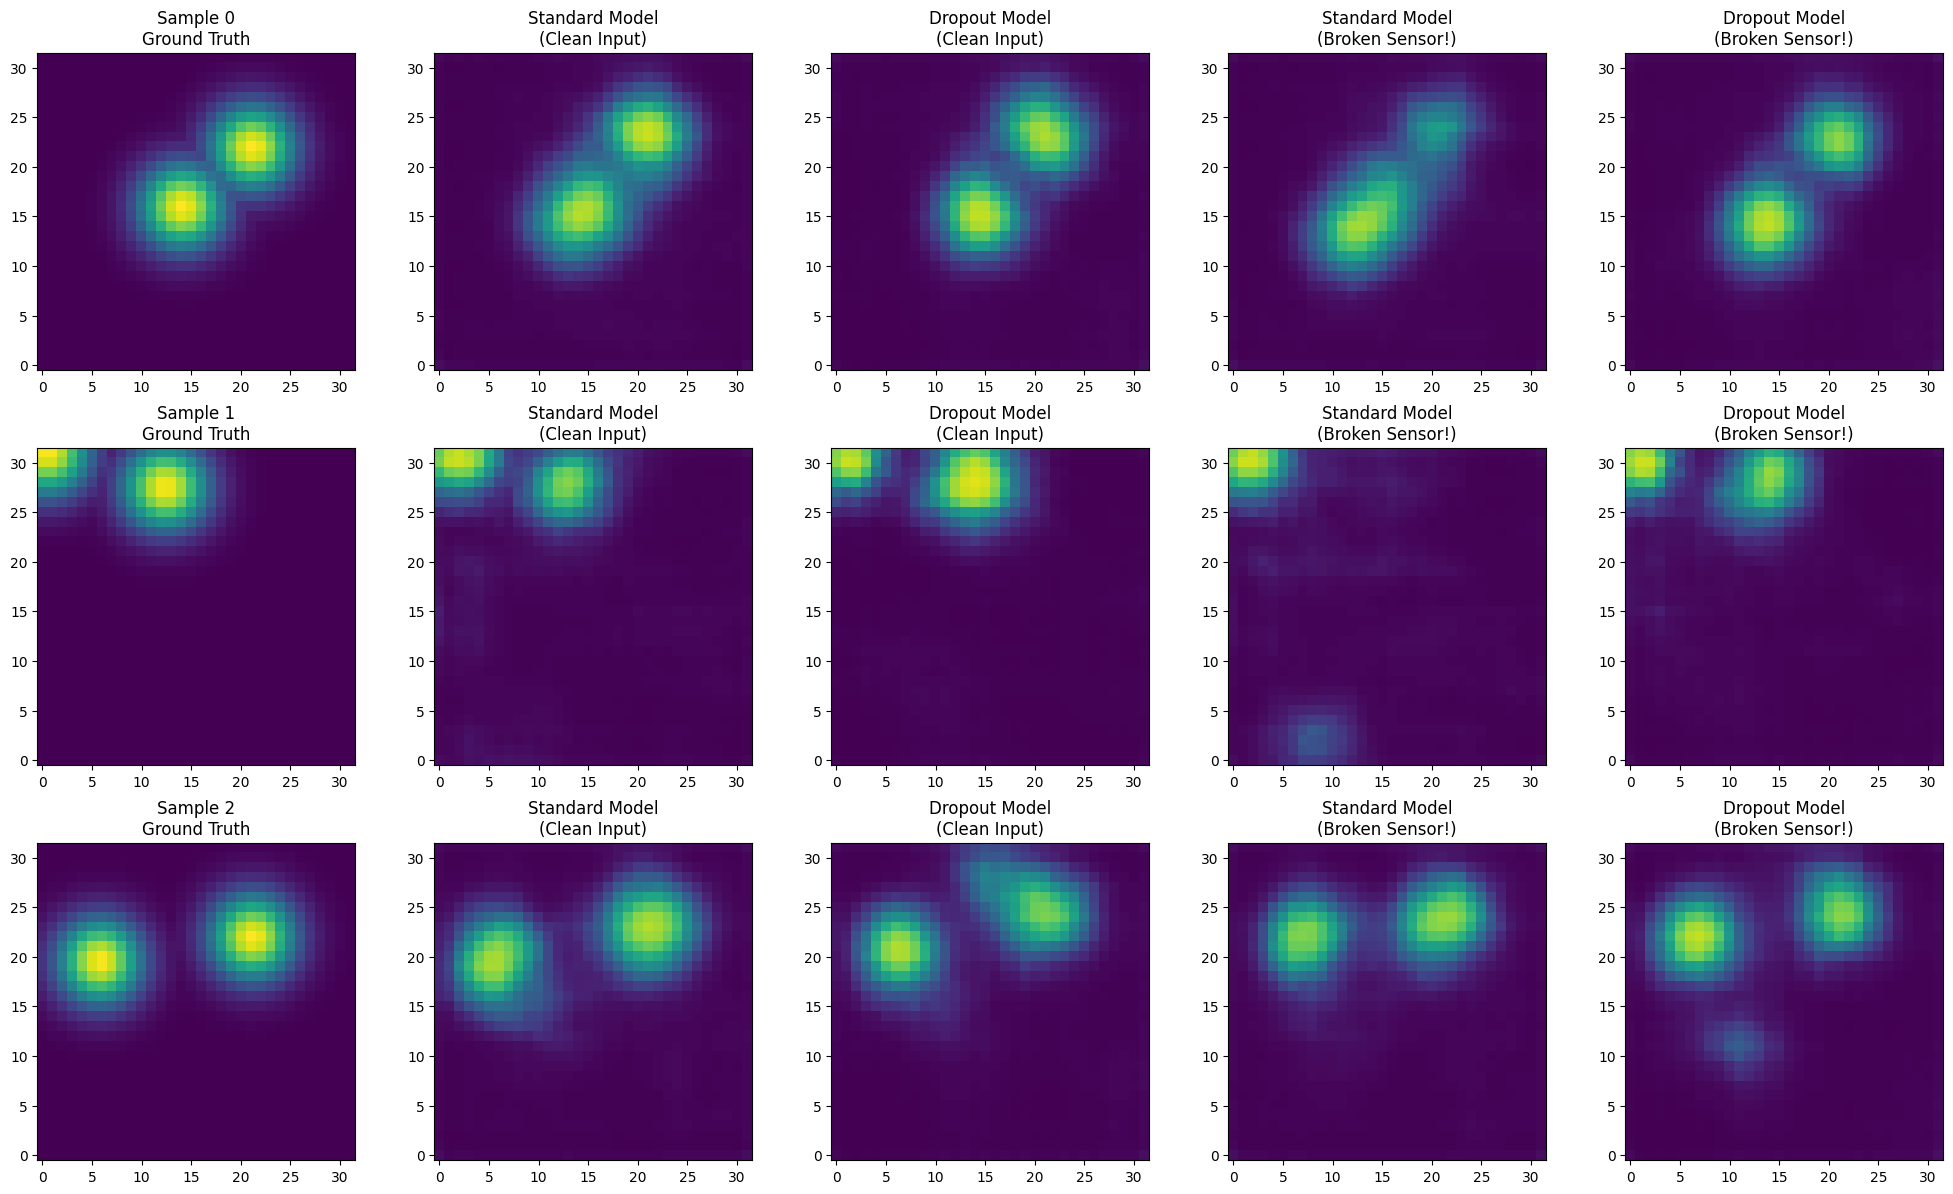

In [63]:
def compare_models_heatmaps(model_std, model_drop, loader, num_samples=3):
    model_std.eval()
    model_drop.eval()

    # get a batch of data
    x_clean, y_true = next(iter(loader))
    x_clean, y_true = x_clean.to(device), y_true.to(device)

    # create a "broken" version of the input (Sensor 0 is dead)
    x_broken = x_clean.clone()
    x_broken[:, 0, :] = 0.0 # force Sensor 0 to be 0

    with torch.no_grad():
        # get predictions on broken data
        pred_std_broken = model_std(x_broken)
        pred_drop_broken = model_drop(x_broken)

        # get predictions on clean data (for comparison)
        pred_std_clean = model_std(x_clean)
        pred_drop_clean = model_drop(x_clean)

    # plotting
    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))

    for i in range(num_samples):
        # ground Truth
        axes[i, 0].imshow(y_true[i, 0].cpu(), origin='lower', vmin=0, vmax=1)
        axes[i, 0].set_title(f"Sample {i}\nGround Truth")

        # standard model
        axes[i, 1].imshow(pred_std_clean[i, 0].cpu(), origin='lower', vmin=0, vmax=1)
        axes[i, 1].set_title("Standard Model\n(Clean Input)")

        # 3. dropout model
        axes[i, 2].imshow(pred_drop_clean[i, 0].cpu(), origin='lower', vmin=0, vmax=1)
        axes[i, 2].set_title("Dropout Model\n(Clean Input)")

        # 4. standard model -> The Failure Case
        axes[i, 3].imshow(pred_std_broken[i, 0].cpu(), origin='lower', vmin=0, vmax=1)
        axes[i, 3].set_title("Standard Model\n(Broken Sensor!)")

        # 5. Dropout Model -> The Robust Case
        axes[i, 4].imshow(pred_drop_broken[i, 0].cpu(), origin='lower', vmin=0, vmax=1)
        axes[i, 4].set_title("Dropout Model\n(Broken Sensor!)")

    plt.tight_layout()
    plt.show()

compare_models_heatmaps(standard_model, dropout_model, test_loader)

In [65]:
def evaluate_model_condition(model, loader, device, criterion, broken_sensor_index=None):
    model.eval()
    total_loss = 0.0
    count = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # simulate broken sensor
            if broken_sensor_index is not None:
                # create a copy of the inputs
                inputs = inputs.clone()
                inputs[:, broken_sensor_index, :] = 0.0

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            count += 1

    return total_loss / count

# use MSE for comparison
criterion = nn.MSELoss()

# standard model (clean vs broken)
loss_std_clean = evaluate_model_condition(standard_model, test_loader, device, criterion, broken_sensor_index=None)
loss_std_broken = evaluate_model_condition(standard_model, test_loader, device, criterion, broken_sensor_index=0) # Break Sensor 0

# dropout model (clean vs broken)
loss_drop_clean = evaluate_model_condition(dropout_model, test_loader, device, criterion, broken_sensor_index=None)
loss_drop_broken = evaluate_model_condition(dropout_model, test_loader, device, criterion, broken_sensor_index=0) # Break Sensor 0

# calculate percentage of improvements
# formula: (Old_Loss - New_Loss) / Old_Loss * 100

# compare models on clean Data
imp_clean = ((loss_std_clean - loss_drop_clean) / loss_std_clean) * 100

# compare models on broken Data
imp_broken = ((loss_std_broken - loss_drop_broken) / loss_std_broken) * 100

# calculate how worse does a model get when a sensor breaks in percentages
deg_std = ((loss_std_broken - loss_std_clean) / loss_std_clean) * 100
deg_drop = ((loss_drop_broken - loss_drop_clean) / loss_drop_clean) * 100

# print the report
print("="*60)
print(f"{'PERFORMANCE COMPARISON REPORT':^60}")
print("="*60)

print(f"\n--- SCENARIO 1: CLEAN INPUT (All Sensors Working) ---")
print(f"Standard Model Loss: {loss_std_clean:.5f}")
print(f"Dropout Model Loss:  {loss_drop_clean:.5f}")

print(f"\n--- SCENARIO 2: BROKEN SENSOR (Sensor 0 Dead) ---")
print(f"Standard Model Loss: {loss_std_broken:.5f}")
print(f"Dropout Model Loss:  {loss_drop_broken:.5f}")
print(f"RESULT: Dropout Model is {imp_broken:.2f}% MORE ACCURATE (lower error) than Standard Model.")

print(f"\n--- ROBUSTNESS ANALYSIS (Self-Degradation) ---")
print(f"When a sensor fails:")
print(f" -> Standard Model error spikes by: {deg_std:.2f}%")
print(f" -> Dropout Model error spikes by:  {deg_drop:.2f}%")

               PERFORMANCE COMPARISON REPORT                

--- SCENARIO 1: CLEAN INPUT (All Sensors Working) ---
Standard Model Loss: 0.00593
Dropout Model Loss:  0.00600

--- SCENARIO 2: BROKEN SENSOR (Sensor 0 Dead) ---
Standard Model Loss: 0.01697
Dropout Model Loss:  0.01037
RESULT: Dropout Model is 38.93% MORE ACCURATE (lower error) than Standard Model.

--- ROBUSTNESS ANALYSIS (Self-Degradation) ---
When a sensor fails:
 -> Standard Model error spikes by: 186.32%
 -> Dropout Model error spikes by:  72.83%


We clearly see that adding sensor dropout in training helps the model generalize and might help in real world scenarios.